In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


15.000042807917142

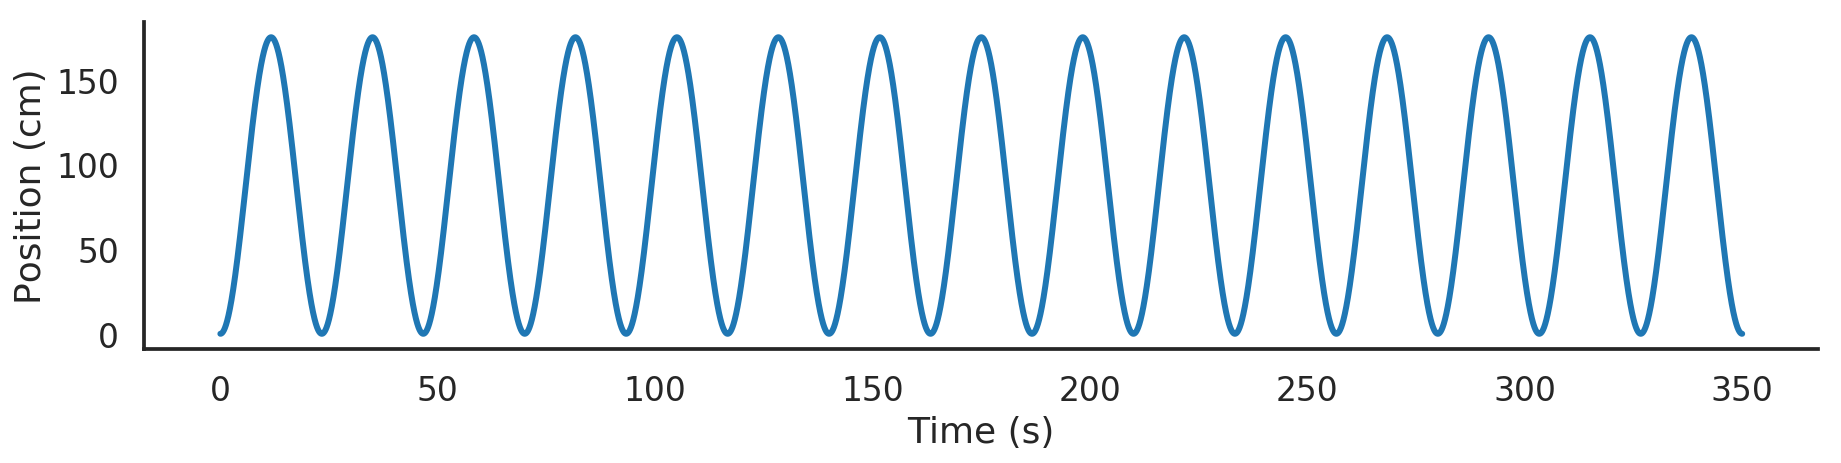

In [3]:
from replay_trajectory_classification.simulate import (
    simulate_time, simulate_linear_distance, simulate_neuron_with_place_field)

sampling_frequency = 1000 # samples / s

track_height = 175 # cm
running_speed = 15 # cm / s
n_runs = 15
n_samples = int(n_runs * sampling_frequency * 2 * track_height / running_speed)

time = simulate_time(n_samples, sampling_frequency)
linear_distance = simulate_linear_distance(time, track_height, running_speed)

plt.figure(figsize=(15, 3))
plt.plot(time, linear_distance, linewidth=3)
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
sns.despine()

avg_speed = np.mean(np.abs(np.diff(linear_distance))) * sampling_frequency
avg_speed

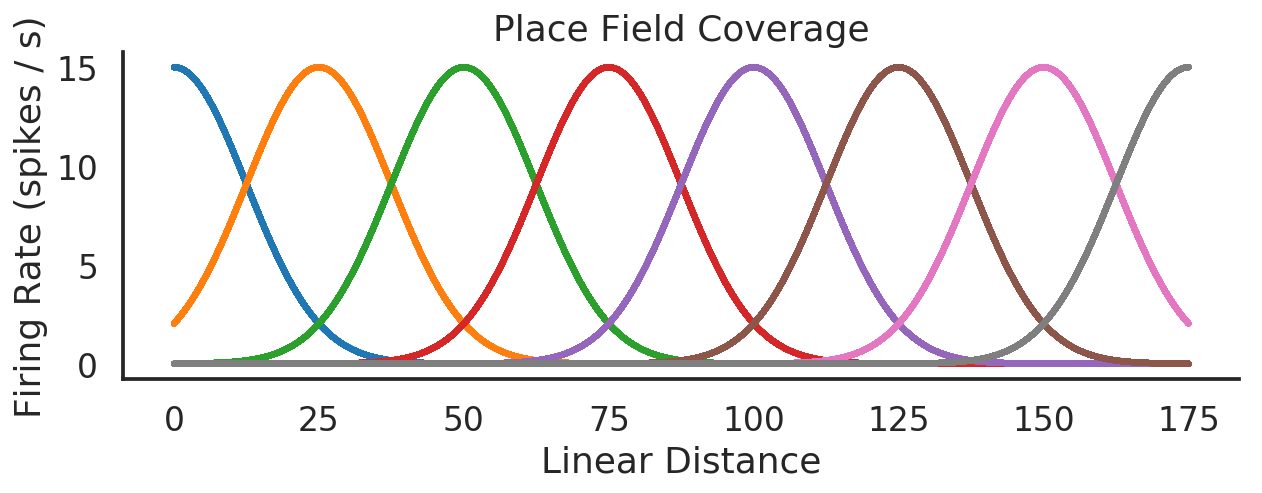

In [4]:
from replay_trajectory_classification.simulate import simulate_place_field_firing_rate

place_field_support = np.arange(0, track_height)
place_field_means = np.arange(0, 200, 25)

place_fields = np.stack(
    [simulate_place_field_firing_rate(place_field_mean, linear_distance, variance=12.5**2)
     for place_field_mean in place_field_means])

plt.figure(figsize=(10, 3))
plt.plot(linear_distance, place_fields.T, linewidth=3)
plt.xlabel('Linear Distance')
plt.ylabel('Firing Rate (spikes / s)')
plt.title('Place Field Coverage')
sns.despine()

(350000, 8)


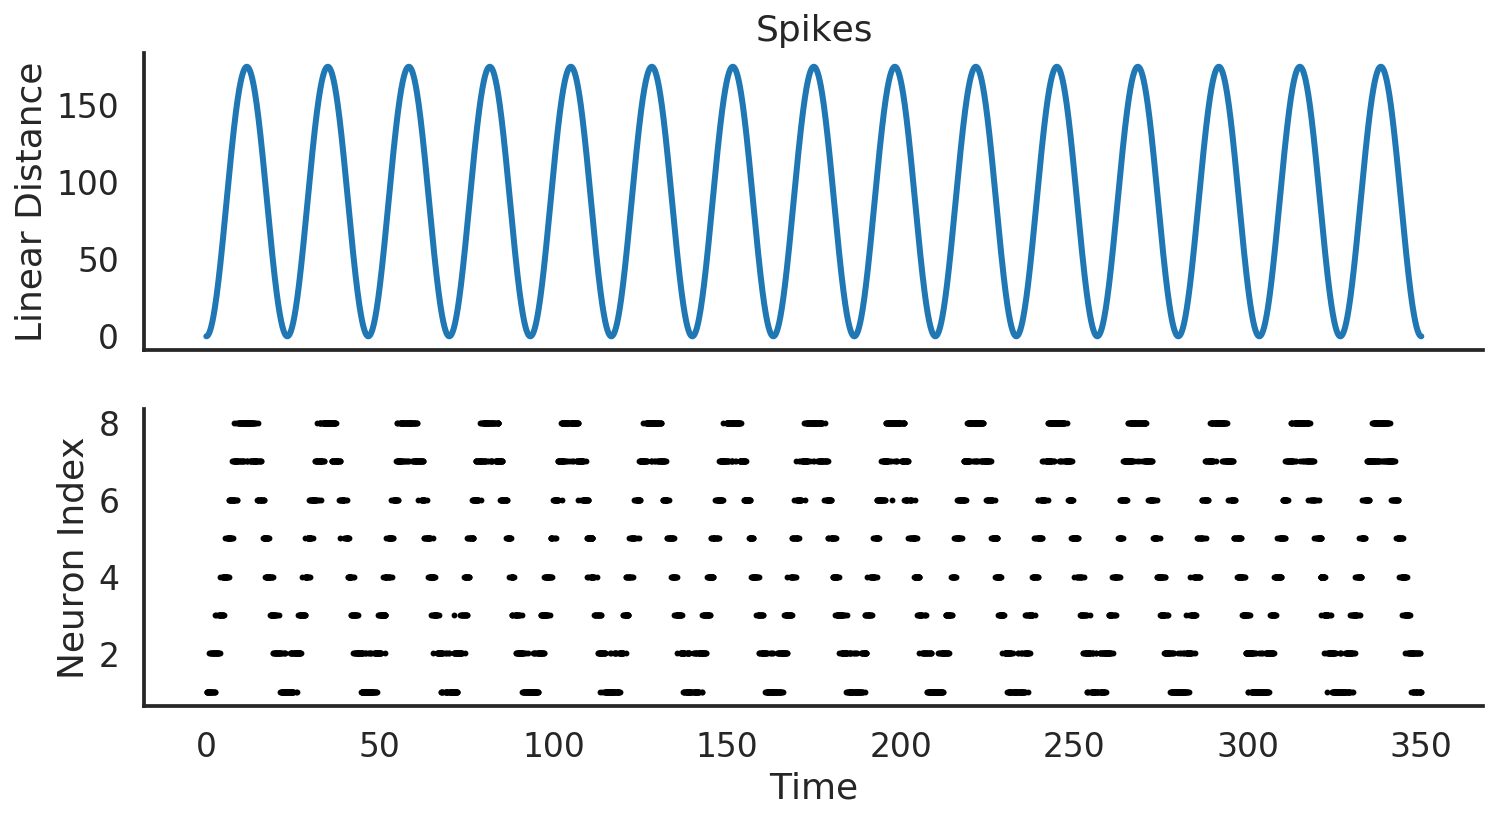

In [5]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field

spikes = np.stack([simulate_neuron_with_place_field(
    place_field_mean, linear_distance, max_rate=15, variance=144,
    sampling_frequency=sampling_frequency)
         for place_field_mean in place_field_means], axis=1)
print(spikes.shape)

spike_ind, neuron_ind = np.nonzero(spikes)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(time, linear_distance, linewidth=3)
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Spikes')
axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_ylabel('Neuron Index')
axes[-1].set_xlabel('Time')
sns.despine()

In [6]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

continuous_transition_types = (
    [['random_walk_minus_identity', 'uniform', 'identity'],
     ['uniform', 'inverse_random_walk', 'uniform'],
     ['random_walk', 'uniform', 'identity']])

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    place_bin_size=np.sqrt(movement_var),
                                    infer_track_interior=False,
                                    continuous_transition_types=continuous_transition_types,
                                    spike_model_penalty=0.5,
                                    discrete_transition_diag=(1 - 1E-2))
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk_minus_identity', 'uniform', 'identity'], ['uniform', 'inverse_random_walk', 'uniform'], ['random_walk', 'uniform', 'identity']],
            discrete_transition_diag=0.99,
            discrete_transition_type='strong_diagonal',
            infer_track_interior=False,
            initial_conditions_type='uniform_on_track', knot_spacing=10,
            movement_var=0.2775842082987607,
            place_bin_size=0.5268626085601071, position_range=None,
            replay_speed=120, spike_model_penalty=0.5)

0.33333333333333337
0.33333333333333337
0.33333333333333337
1.0


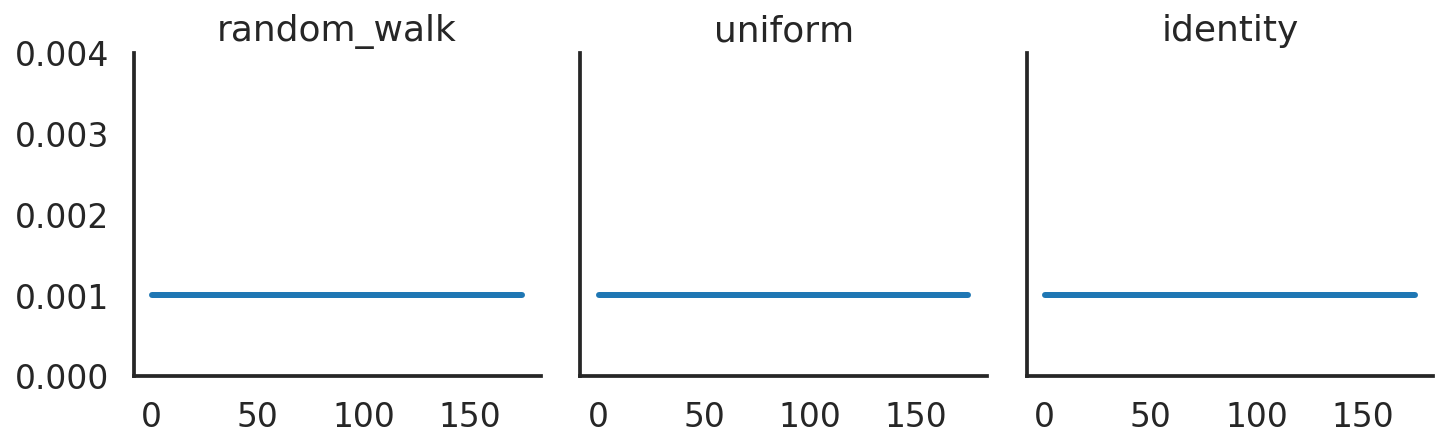

In [8]:
fig, axes = plt.subplots(1, 3, constrained_layout=True, sharey=True, figsize=(10, 3))
states = np.diag(classifier.continuous_transition_types)

for ax, ic, state in zip(axes.flat, classifier.initial_conditions_.squeeze(), states):
    ax.plot(classifier.place_bin_centers_, ic, linewidth=3)
    ax.set_title(state)
    print(ic.sum())
plt.ylim((0, 0.004))
sns.despine()
print(classifier.initial_conditions_.sum())

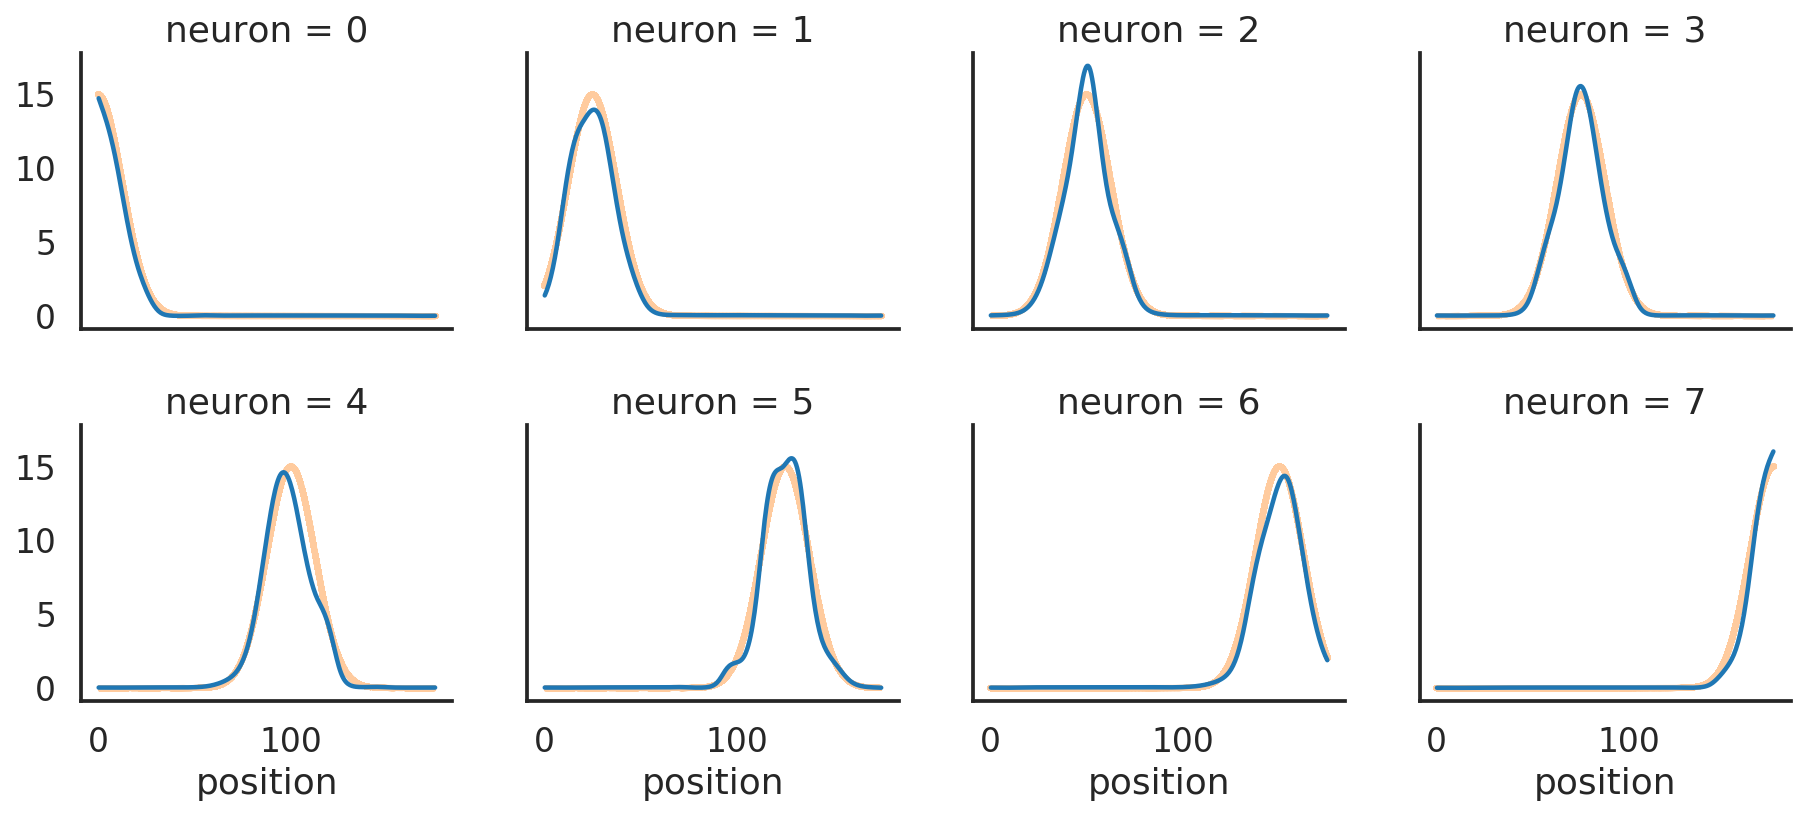

In [9]:
g = (classifier.place_fields_ * sampling_frequency).plot(x='position', col='neuron', col_wrap=4)

for ax, field in zip(g.axes.flat, place_fields):
    ax.plot(linear_distance, field, linestyle='--', zorder=0, linewidth=3, alpha=0.4)
sns.despine()

True
True
True
True
True
True
True
True
True


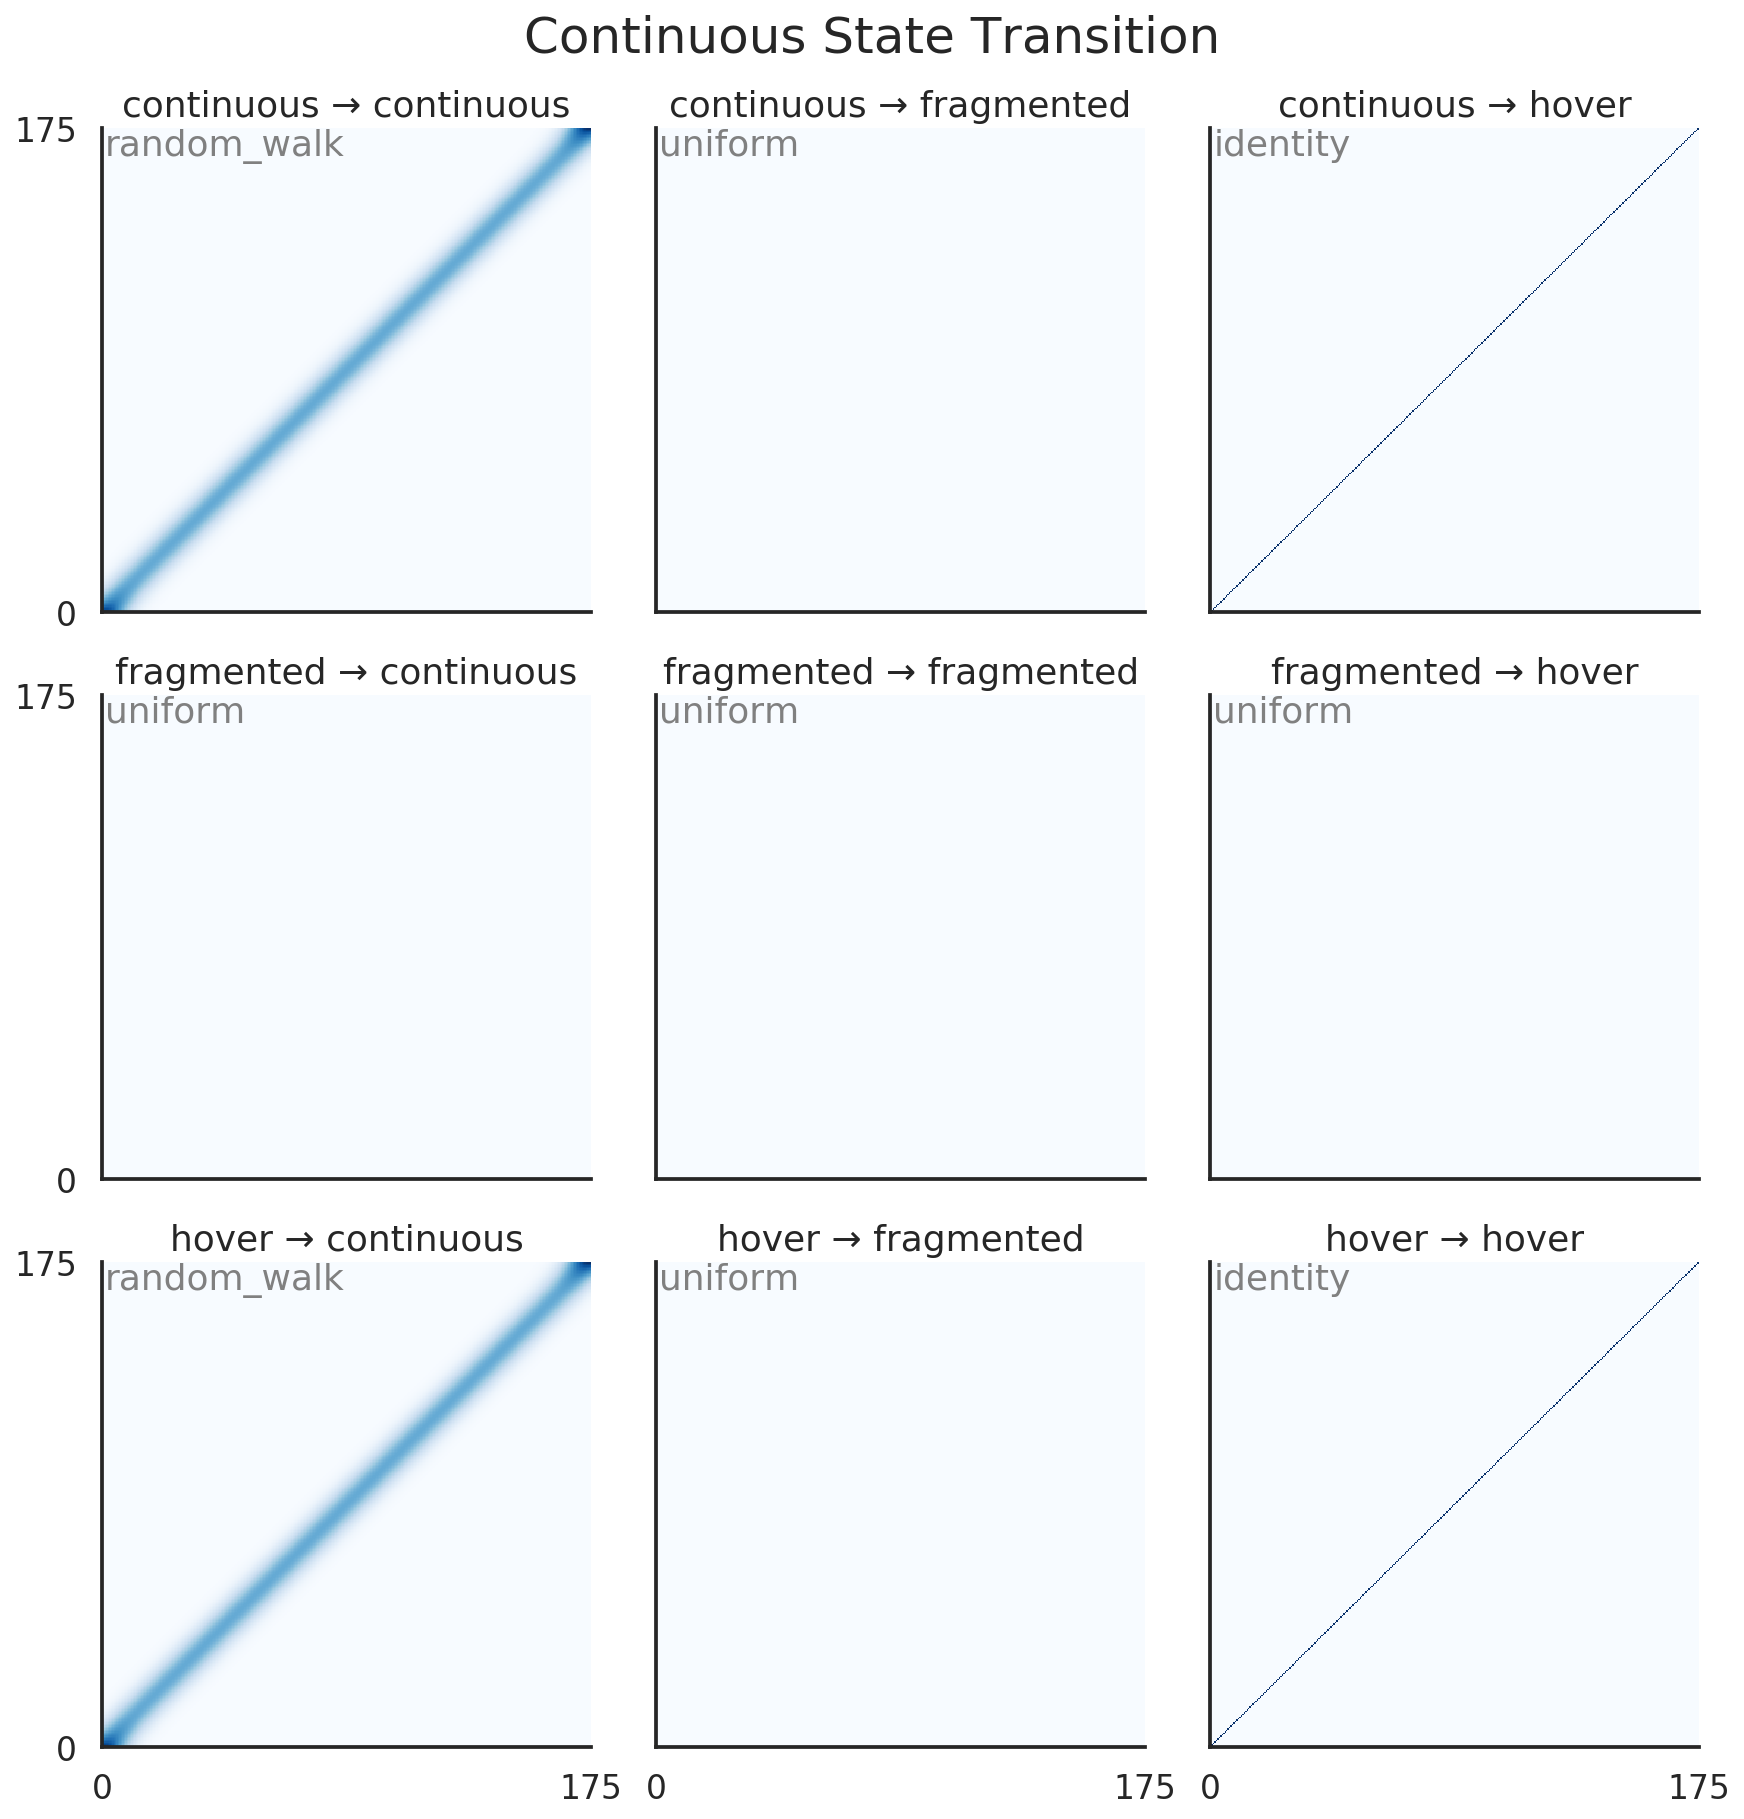

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12),
                         sharex=True, sharey=True,
                         constrained_layout=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)
x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
state_names = ['continuous', 'fragmented', 'hover']
bin_min, bin_max = 0.0, track_height

for j in range(3):
    for k in range(3):
        axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues')
        axes[j, k].text(1, 175, continuous_transition_types[j, k], color='grey',
                        va='top')
        axes[j, k].set_title(f'{state_names[j]} → {state_names[k]}')
        axes[j, k].set_xticks((bin_min, bin_max))
        axes[j, k].set_yticks((bin_min, bin_max))
        print(np.allclose(classifier.continuous_state_transition_[0, 0].sum(axis=1), 1.0))
        
plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
plt.suptitle('Continuous State Transition', y=1.04, fontsize=25)
sns.despine()

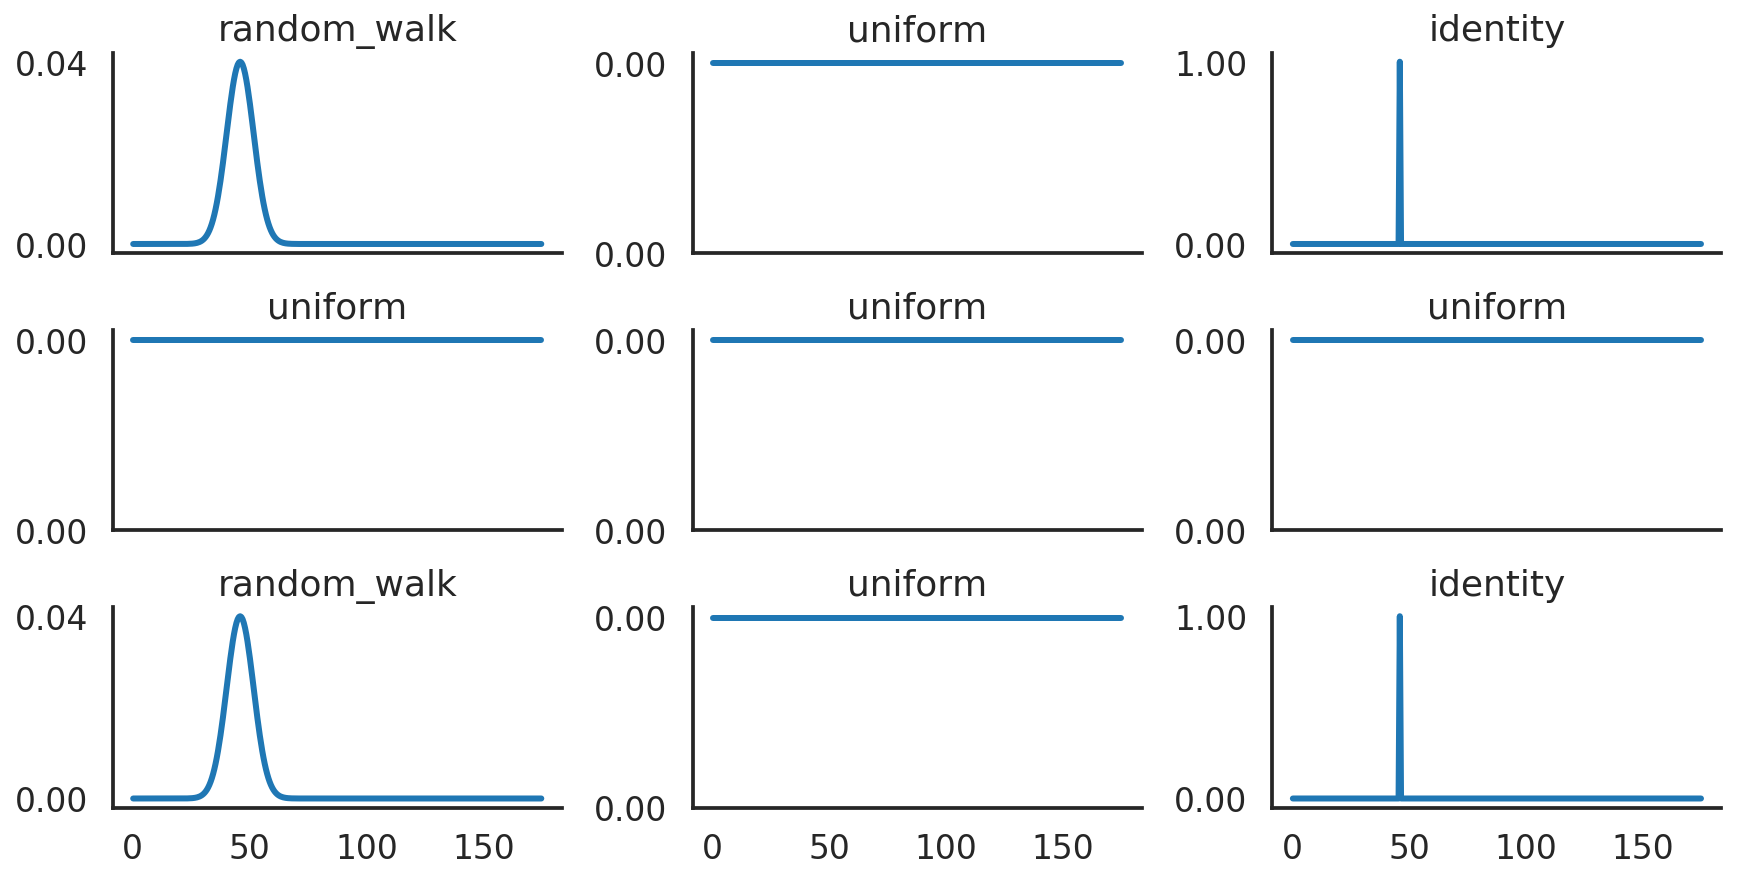

In [11]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(3, 3, figsize=(12, 6),
                         sharex=True, sharey=False,
                         constrained_layout=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)

def format_func(value, tick_number):
    return "%.2f" % value

for j in range(3):
    for k in range(3):
        row = classifier.continuous_state_transition_[j, k, 175 // 2]
        axes[j, k].plot(classifier.place_bin_centers_,
                        row, linewidth=3)
        axes[j, k].set_title(continuous_transition_types[j, k])
        axes[j, k].set_yticks((0, row.max()))
        axes[j, k].yaxis.set_major_formatter(plt.FuncFormatter(format_func))
sns.despine()

True

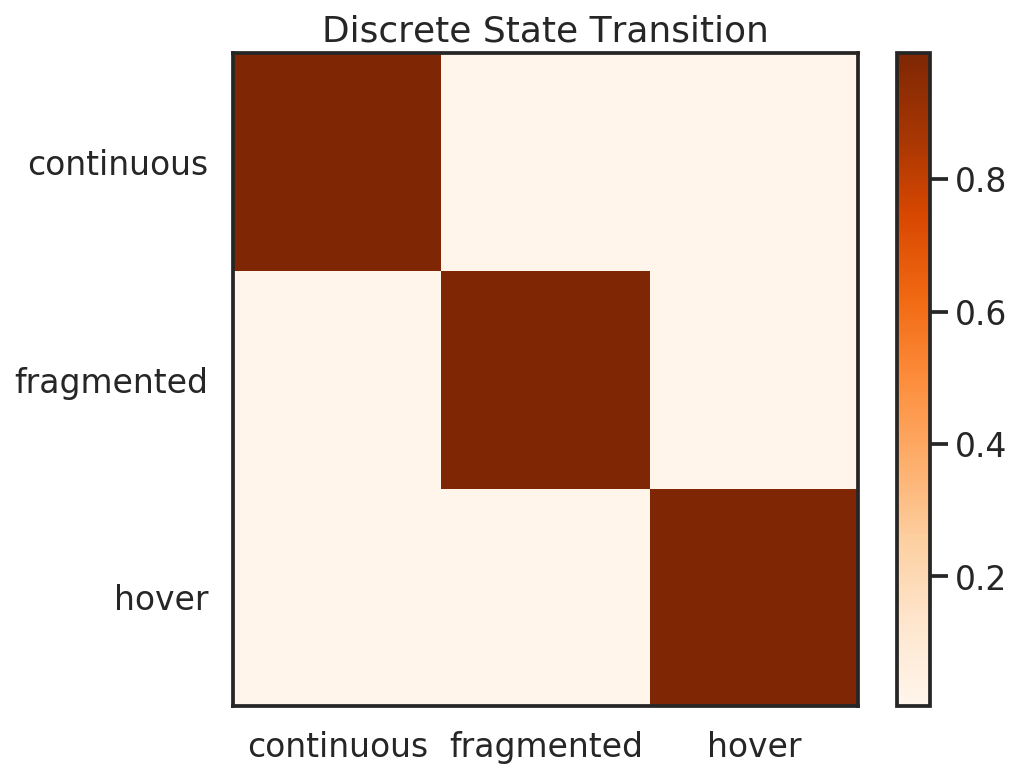

In [12]:
state_names = ['continuous', 'fragmented', 'hover']
edges = np.arange(0.5, 4.5)
x_edges, y_edges = np.meshgrid(edges, edges)
plt.figure(figsize=(7, 6))
plt.pcolormesh(x_edges, y_edges, np.fliplr(classifier.discrete_state_transition_), cmap='Oranges')
plt.xticks(ticks=range(1, 4), labels=state_names)
plt.yticks(ticks=range(1, 4), labels=state_names[::-1])
plt.colorbar()
plt.title('Discrete State Transition')
np.allclose(classifier.discrete_state_transition_.sum(axis=1), 1.0)

(0, 1.05)

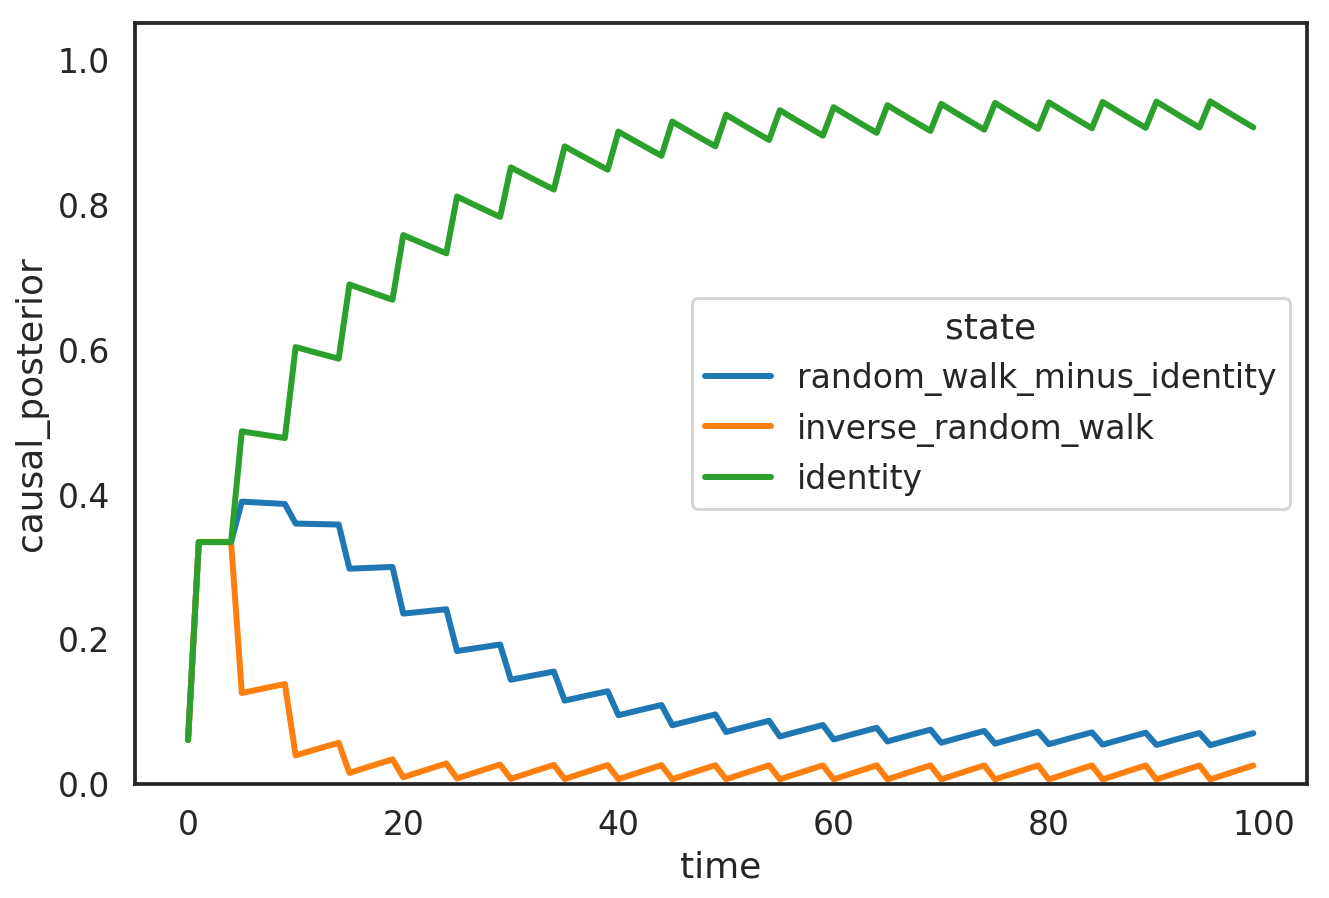

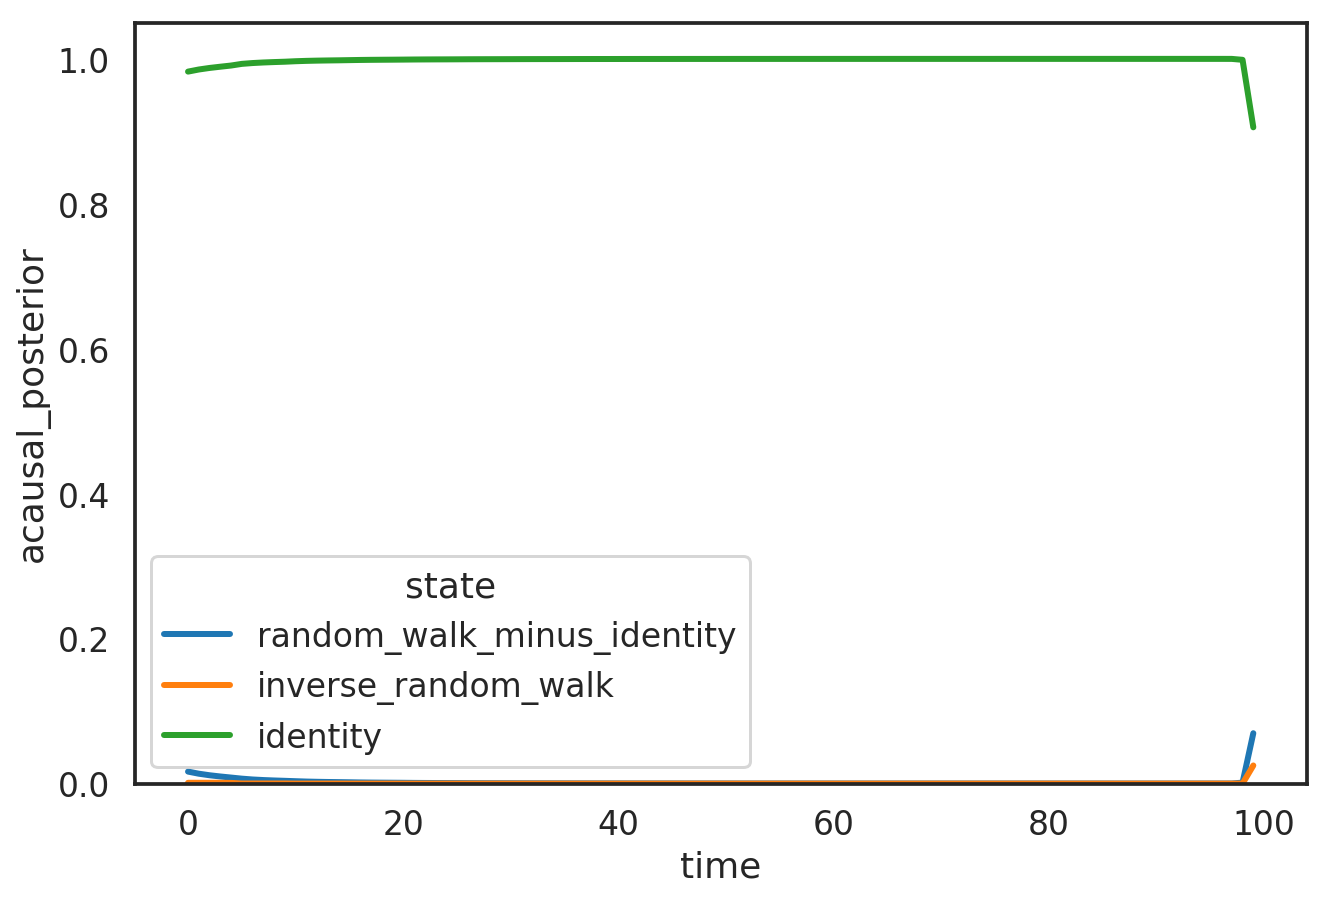

In [7]:
test_spikes = np.zeros((100, 8))
test_spikes[::5, 3] = 1

results = classifier.predict(test_spikes)
results.sum('position').causal_posterior.plot(x='time', hue='state', size=7, linewidth=3)
plt.ylim((0, 1.05))

results.sum('position').acausal_posterior.plot(x='time', hue='state', size=7, linewidth=3)
plt.ylim((0, 1.05))

(0, 1.05)

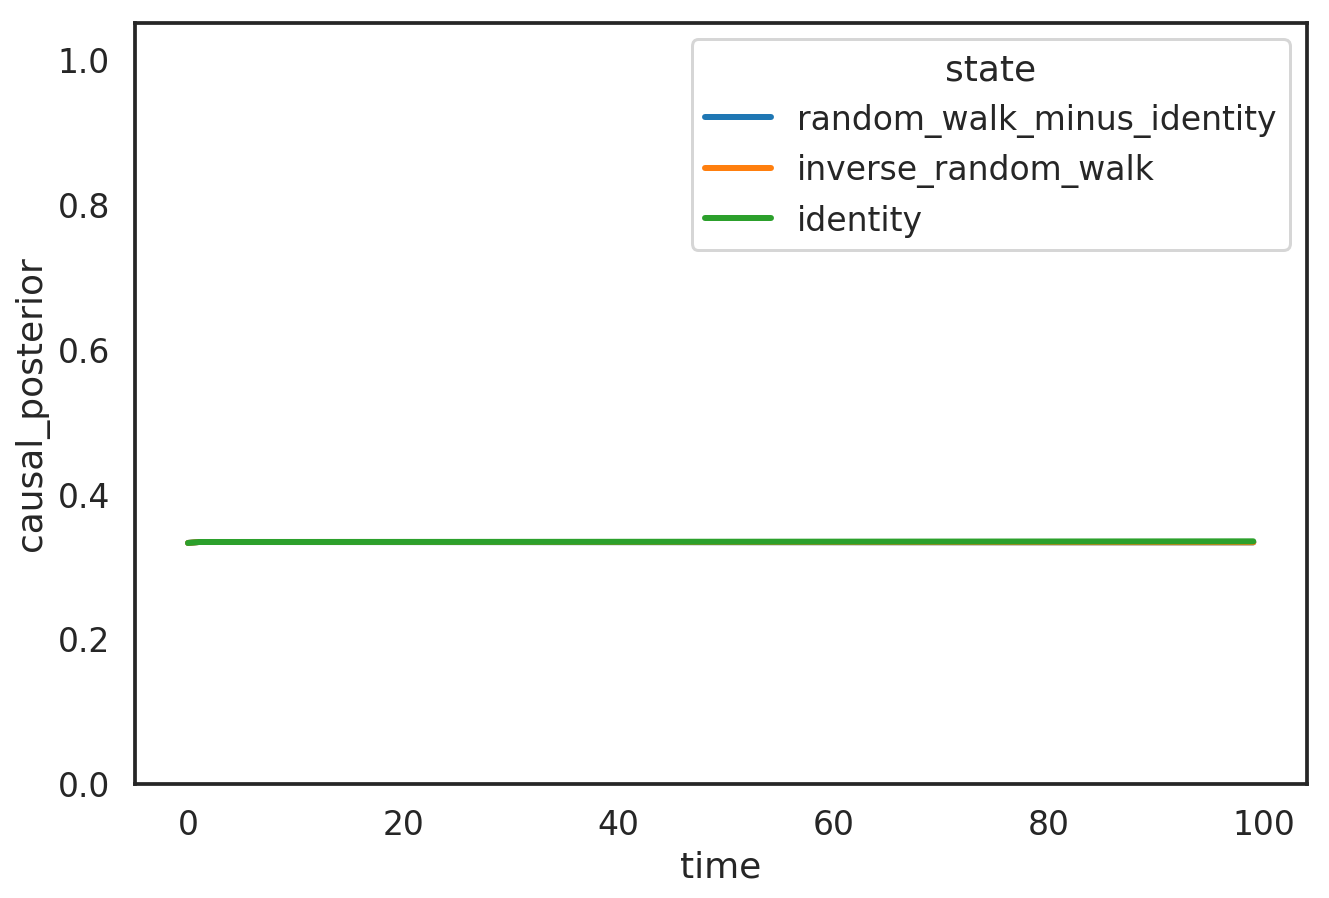

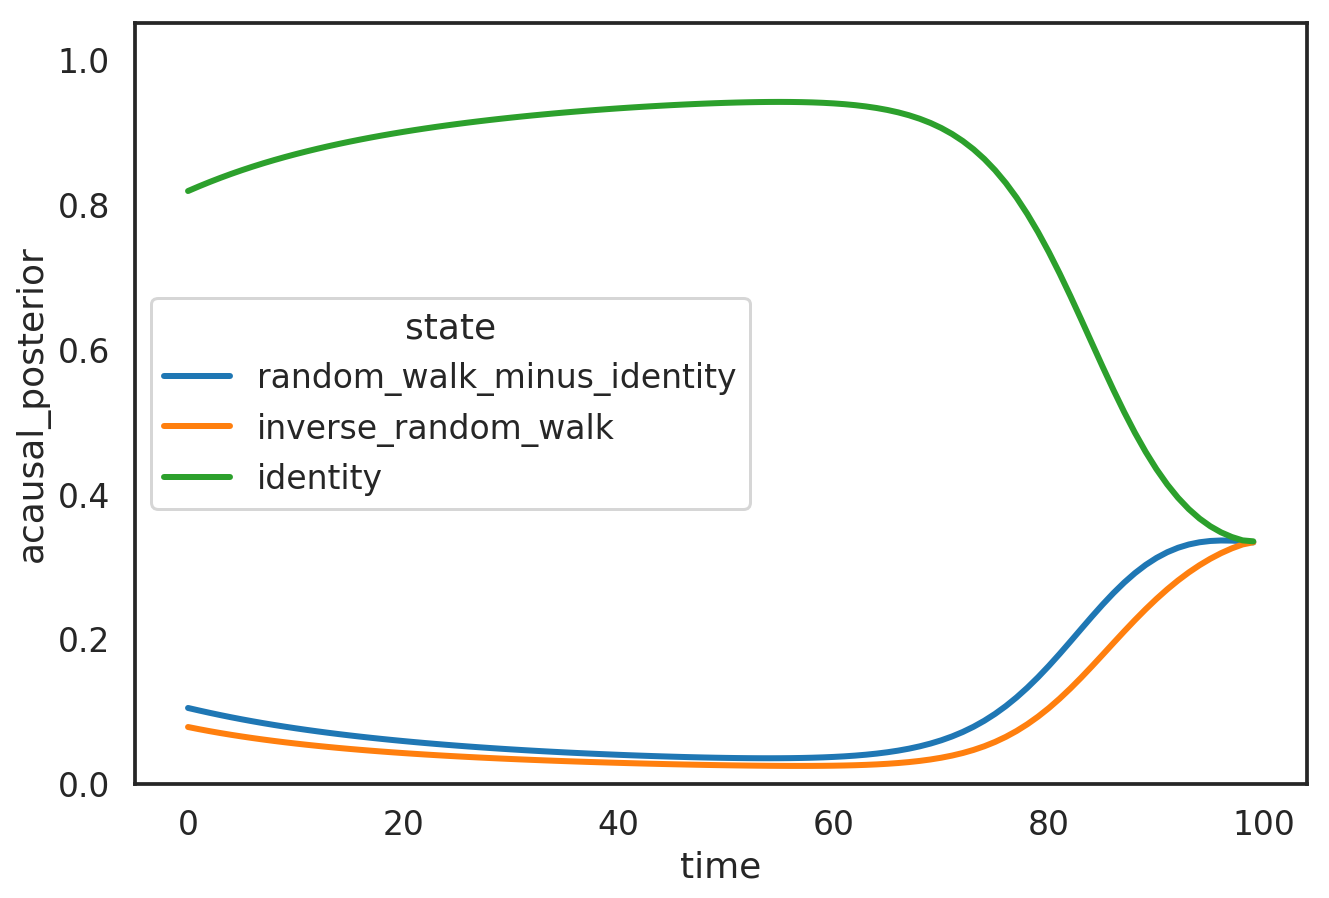

In [8]:
test_spikes = np.zeros((100, 8))

results = classifier.predict(test_spikes)
results.sum('position').causal_posterior.plot(x='time', hue='state', size=7, linewidth=3)
plt.ylim((0, 1.05))

results.sum('position').acausal_posterior.plot(x='time', hue='state', size=7, linewidth=3)
plt.ylim((0, 1.05))

(0, 1.05)

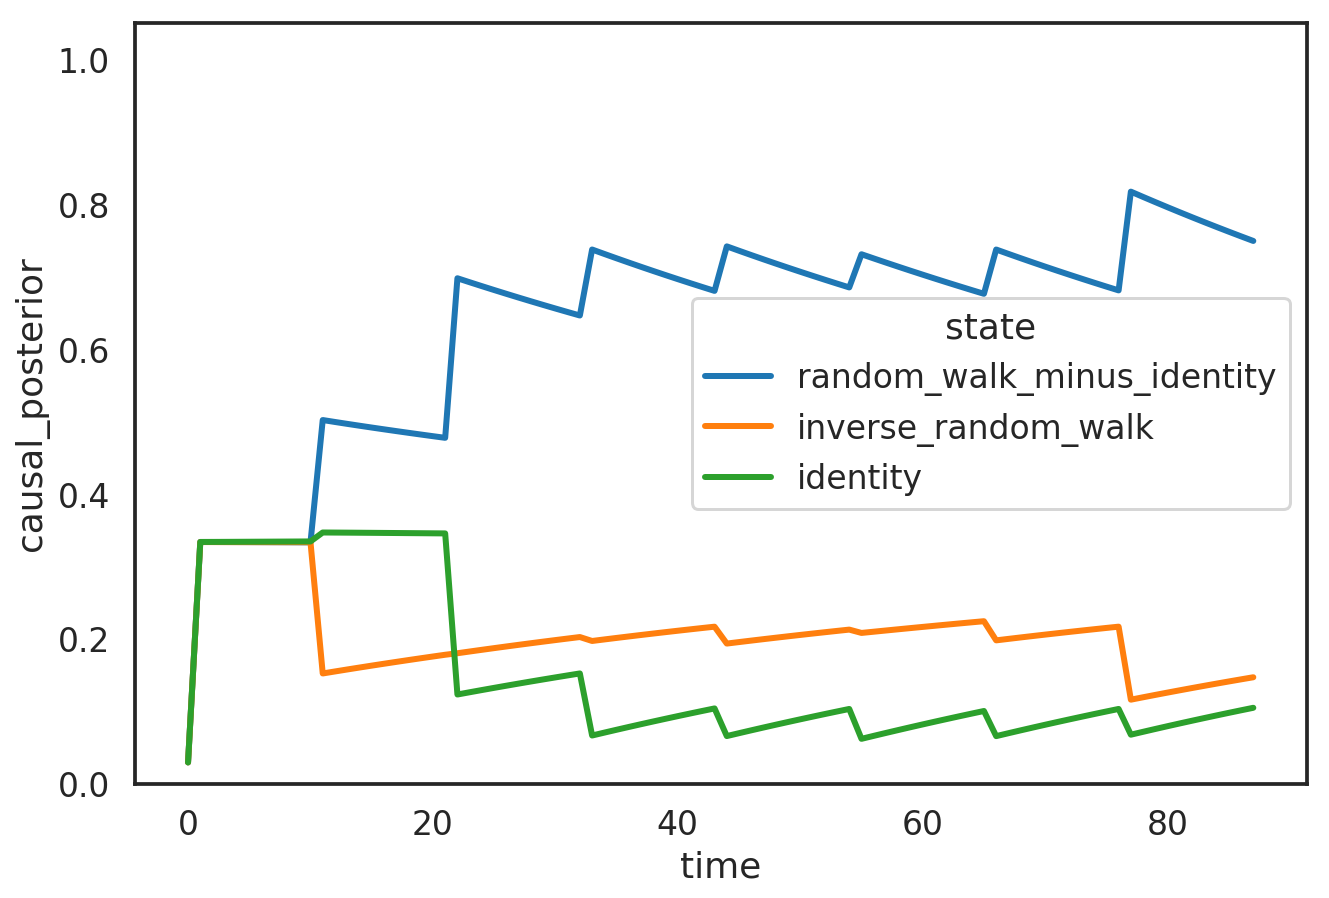

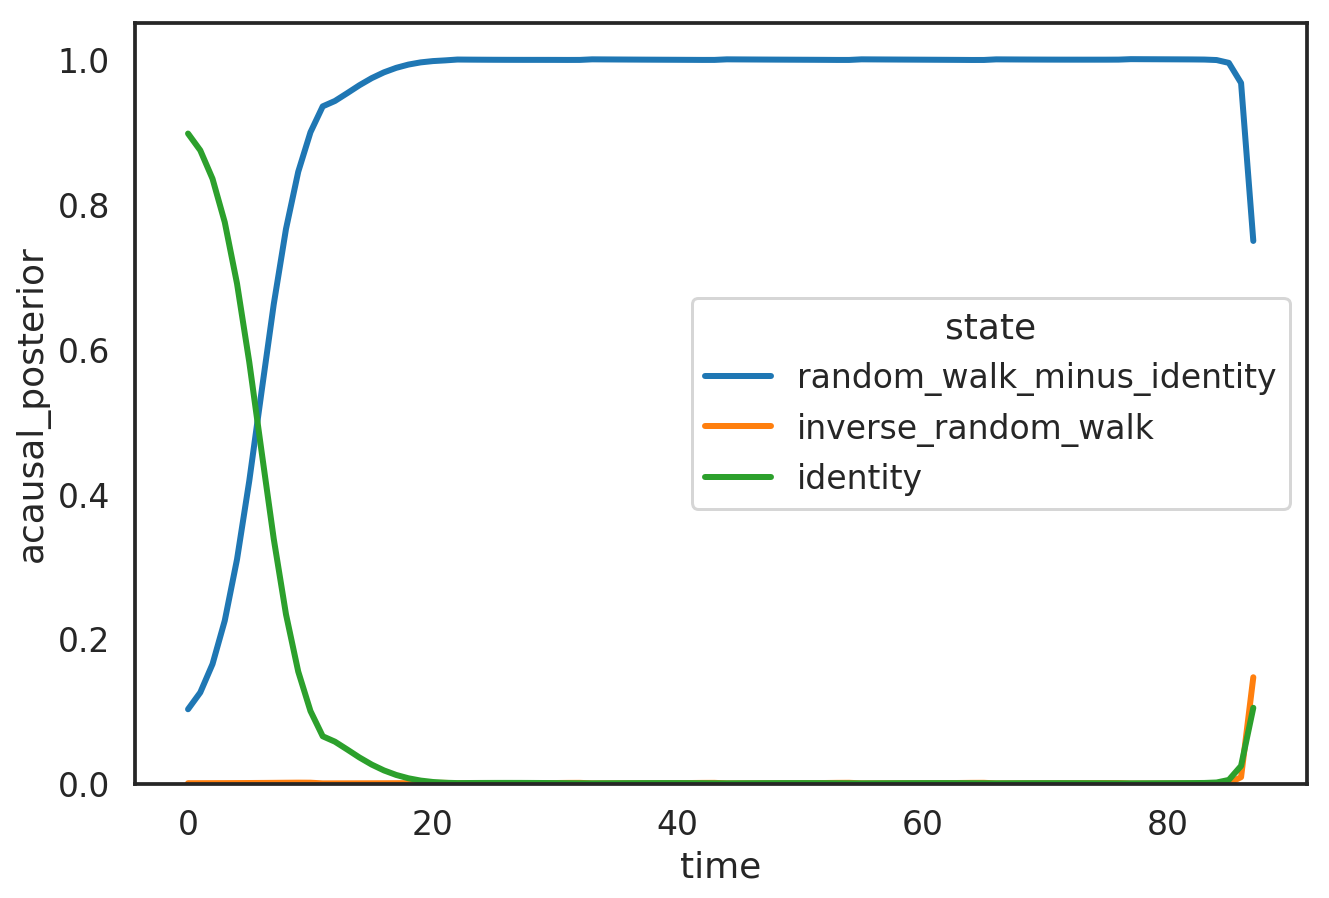

In [9]:
gap = 11
test_spikes = np.zeros((8 * gap, 8))

test_spikes[(np.arange(0, 8 * gap, gap), np.arange(8))] = 1

results = classifier.predict(test_spikes)
results.sum('position').causal_posterior.plot(x='time', hue='state', size=7, linewidth=3)
plt.ylim((0, 1.05))

results.sum('position').acausal_posterior.plot(x='time', hue='state', size=7, linewidth=3)
plt.ylim((0, 1.05))

In [15]:
from replay_trajectory_classification import SortedSpikesDecoder

decoder = SortedSpikesDecoder(place_bin_size=classifier.place_bin_size,
                    replay_speed=classifier.replay_speed,
                    movement_var=classifier.movement_var,
                    position_range=classifier.position_range,
                    knot_spacing=classifier.knot_spacing,
                    spike_model_penalty=classifier.spike_model_penalty,
                    transition_type='random_walk',
                    initial_conditions_type=classifier.initial_conditions_type,
                    infer_track_interior=classifier.infer_track_interior)
decoder.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(infer_track_interior=False,
          initial_conditions_type='uniform_on_track', knot_spacing=10,
          movement_var=0.2775842082987607,
          place_bin_size=0.5268626085601071, position_range=None,
          replay_speed=120, spike_model_penalty=0.5,
          transition_type='random_walk')

True


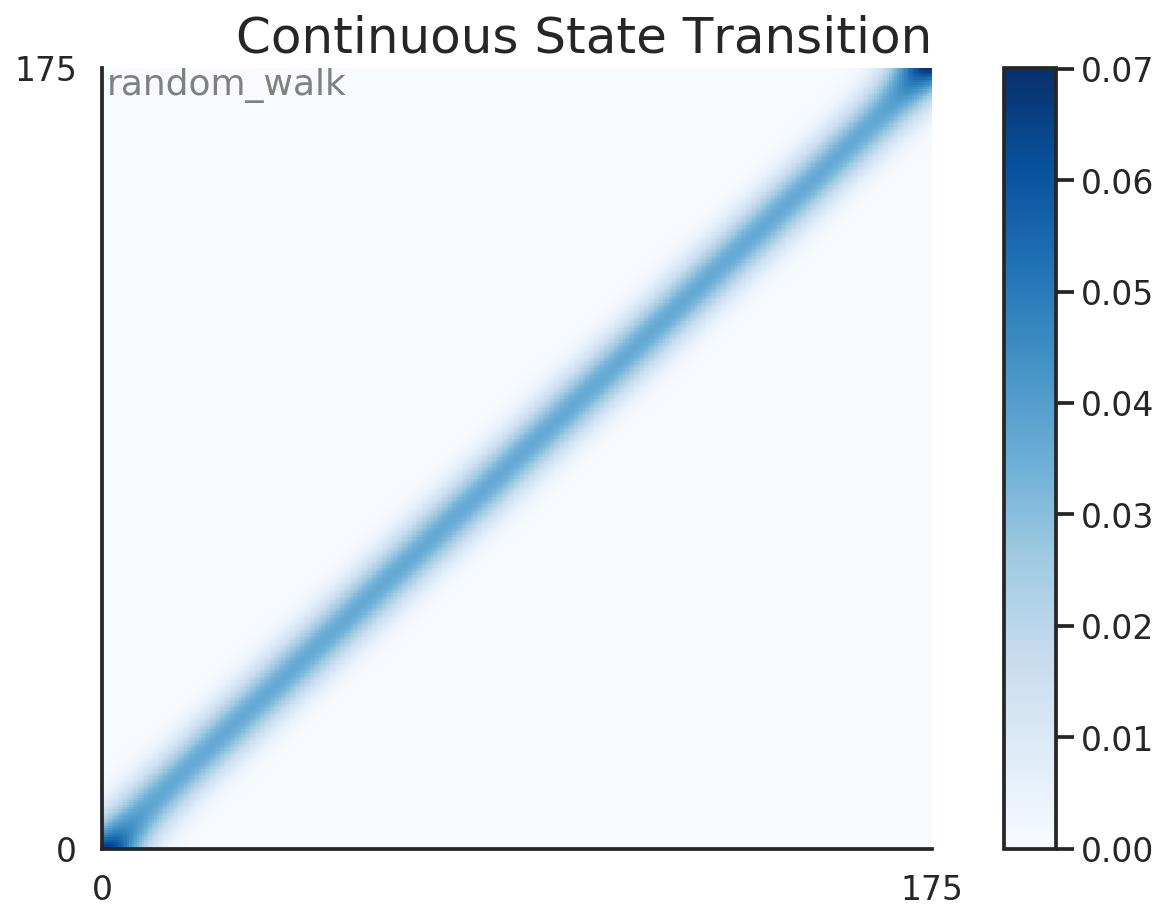

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6),
                         sharex=True, sharey=True,
                         constrained_layout=True)
x, y = np.meshgrid(decoder.place_bin_edges_, decoder.place_bin_edges_)
bin_min, bin_max = 0.0, track_height

h = ax.pcolormesh(x, y, decoder.state_transition_, cmap='Blues')
ax.text(1, 175, decoder.transition_type, color='grey',
                va='top')
ax.set_xticks((bin_min, bin_max))
ax.set_yticks((bin_min, bin_max))
print(np.allclose(decoder.state_transition_.sum(axis=1), 1.0))
        
plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
plt.colorbar(h, ax=ax)
plt.suptitle('Continuous State Transition', y=1.04, fontsize=25)
sns.despine()

1616.3793103448277

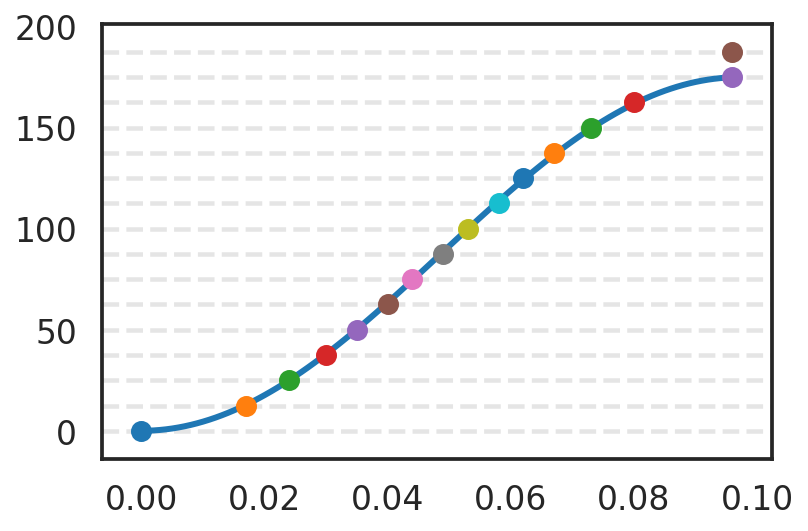

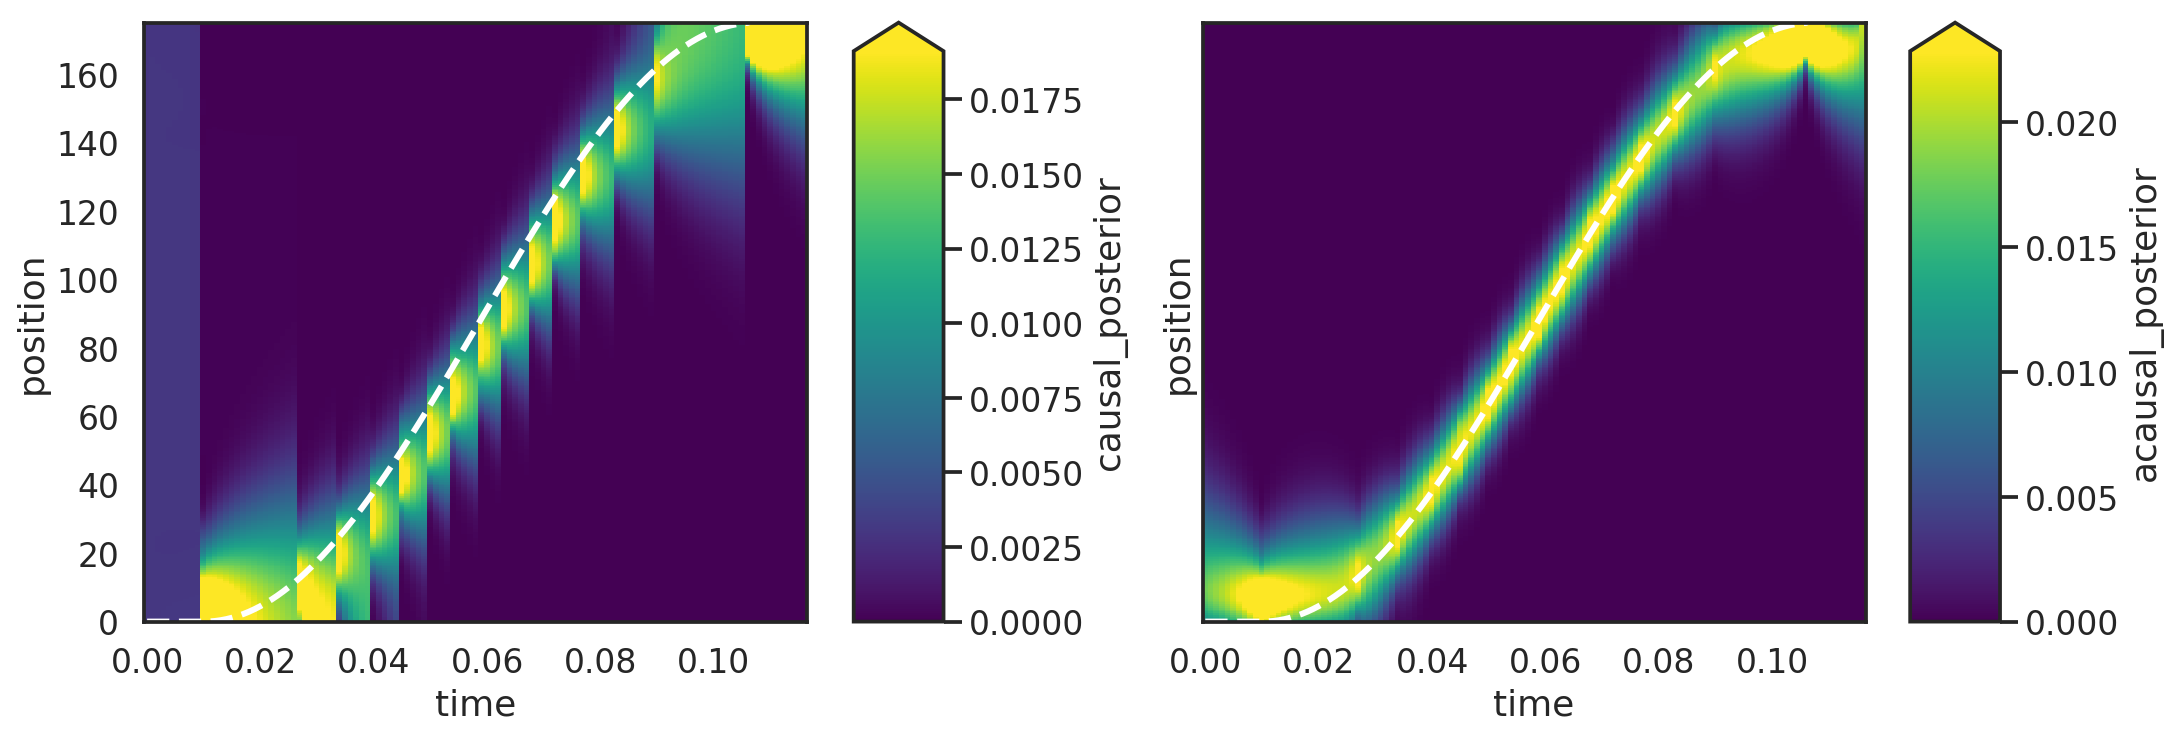

In [21]:
def get_replay_continuous(running_speed, sampling_frequency, track_height, replay_speedup=120, n_runs=0.5):
    replay_speed = running_speed * replay_speedup
    n_samples = int(n_runs * sampling_frequency * 2 * track_height / replay_speed)
    time = simulate_time(n_samples, sampling_frequency)
    linear_distance = simulate_linear_distance(time, track_height, replay_speed)
    
    return time, linear_distance

replay_time, replay_position = get_replay_continuous(
    running_speed, sampling_frequency, track_height, replay_speedup=classifier.replay_speed)
plt.plot(replay_time, replay_position, linewidth=3)

min_times_ind = np.argmin(np.abs(replay_position[:, np.newaxis] - place_field_means), axis=0)
for mean, ind in zip(place_field_means, min_times_ind):
    plt.scatter(replay_time[ind], mean, zorder=10)
    plt.axhline(mean, zorder=0, color='black', linestyle='--', alpha=0.1)
    
    
n_neurons = spikes.shape[1]
test_spikes = np.zeros((replay_time.size + 20, n_neurons))
test_spikes[(min_times_ind + 10, np.arange(n_neurons),)] = 1.0
replay_time = np.arange(replay_time.size + 20) / sampling_frequency
replay_position = np.concatenate((np.zeros(10,), replay_position, place_field_means.max() * np.ones(10,)))

results = decoder.predict(test_spikes, time=replay_time)

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 5),
                         sharex=True, sharey=True)
results.causal_posterior.plot(x='time', y='position', ax=axes[0], robust=True, vmin=0.0)
axes[0].plot(replay_time, replay_position, linewidth=3, color='white', linestyle='--')
results.acausal_posterior.plot(x='time', y='position', ax=axes[1], robust=True, vmin=0.0)
axes[1].plot(replay_time, replay_position, linewidth=3, color='white', linestyle='--')

np.mean(np.abs(np.diff(replay_position))) * sampling_frequency

In [22]:
import os
from tqdm.autonotebook import tqdm

folder = 'decoder_continuous'
os.makedirs(folder, exist_ok=True)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)

for t_ind, t in enumerate(tqdm(results.time)):
    fig, axes = plt.subplots(2, 1, figsize=(7, 5), constrained_layout=True)
    results.causal_posterior.sel(time=t).plot(x='position', linewidth=5, ax=axes[0])
    axes[0].set_xlim((0, results.position.max()))
    axes[0].set_ylim((0, 0.05))
    axes[0].set_ylabel('Posterior')
    axes[1].scatter(results.time[spike_time_ind], neuron_ind)
    axes[1].axvline(np.asarray(t))
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Neuron Index')
    axes[1].set_yticks([])
    figure_name = (f'temp_{t_ind:04d}.png')
    figure_path = os.path.join(folder, figure_name)
    sns.despine()
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(plt.gcf())

/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


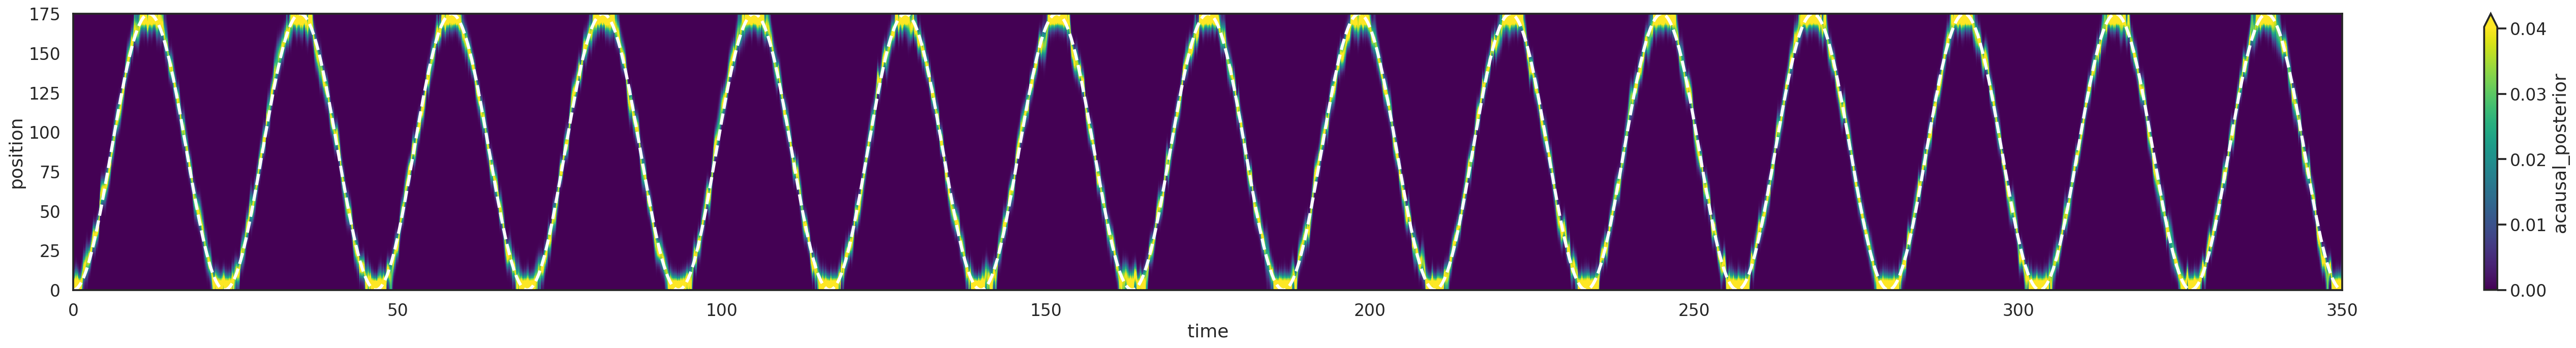

In [26]:
from replay_trajectory_classification import SortedSpikesDecoder

decoder_no_speedup = SortedSpikesDecoder(place_bin_size=np.sqrt(movement_var),
                    replay_speed=1,
                    movement_var=classifier.movement_var,
                    position_range=classifier.position_range,
                    knot_spacing=classifier.knot_spacing,
                    spike_model_penalty=classifier.spike_model_penalty,
                    transition_type='random_walk',
                    initial_conditions_type=classifier.initial_conditions_type,
                    infer_track_interior=classifier.infer_track_interior)
decoder_no_speedup.fit(linear_distance, spikes)
no_speedup_results = decoder_no_speedup.predict(spikes, time=time)
no_speedup_results.acausal_posterior.plot(x='time', y='position',
                                          robust=True, vmin=0.0, size=5, aspect=7)
plt.plot(time, linear_distance, linewidth=3, color='white', linestyle='--')

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


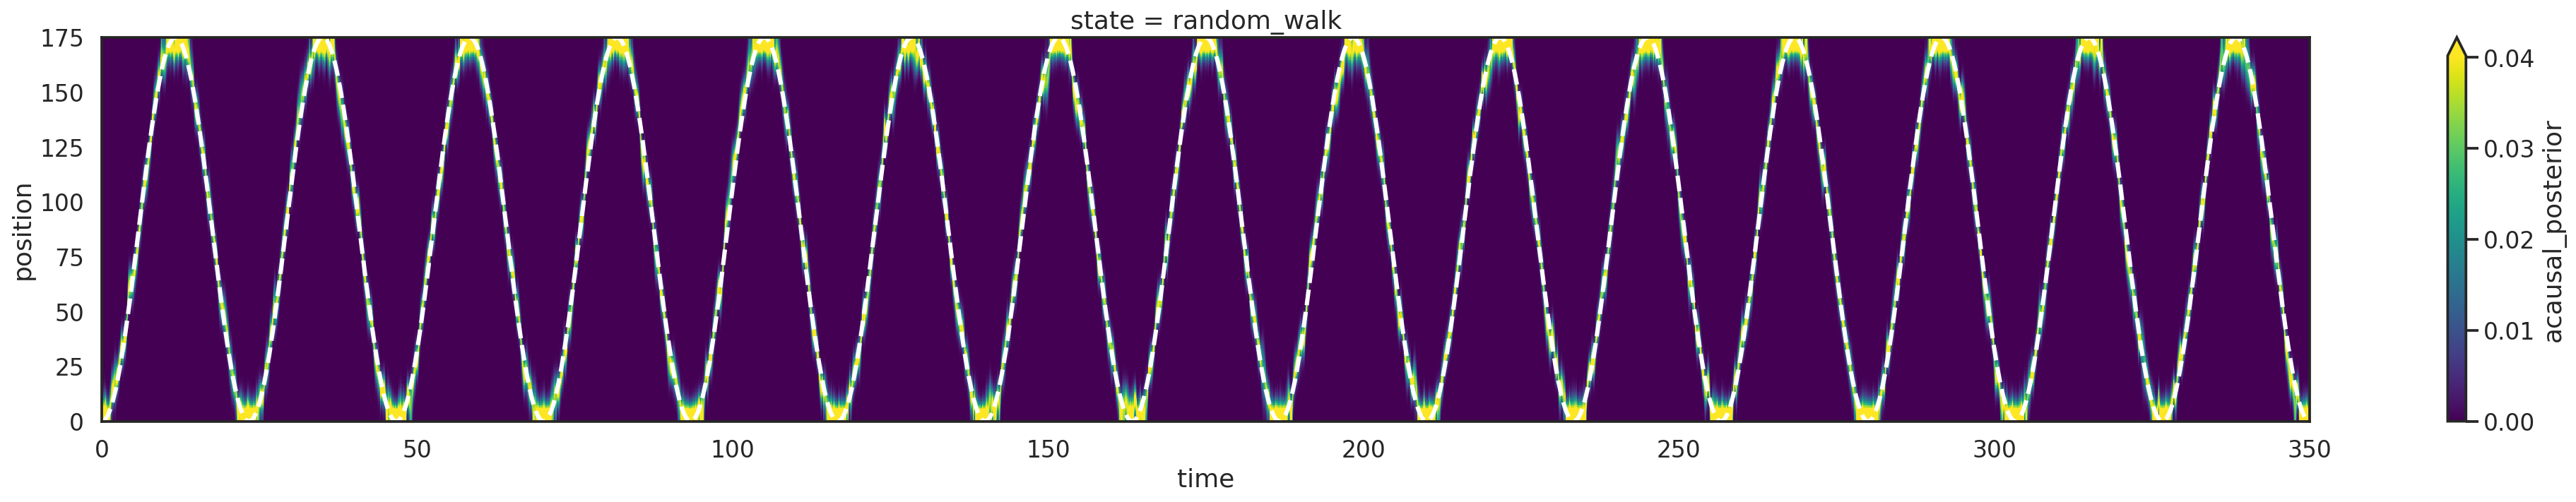

In [32]:
classifier_no_speedup = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=1,
                                    place_bin_size=np.sqrt(movement_var),
                                    infer_track_interior=False,
                                    continuous_transition_types=[['random_walk']],
                                    discrete_transition_type='identity',
                                    spike_model_penalty=0.5,
                                    discrete_transition_diag=(1 - 1E-4))
classifier_no_speedup.fit(linear_distance, spikes)
no_speedup_results = classifier_no_speedup.predict(spikes, time=time)
no_speedup_results.acausal_posterior.plot(x='time', y='position',
                                          robust=True, vmin=0.0, size=5, aspect=7)
plt.plot(time, linear_distance, linewidth=3, color='white', linestyle='--')

15.000042807917142

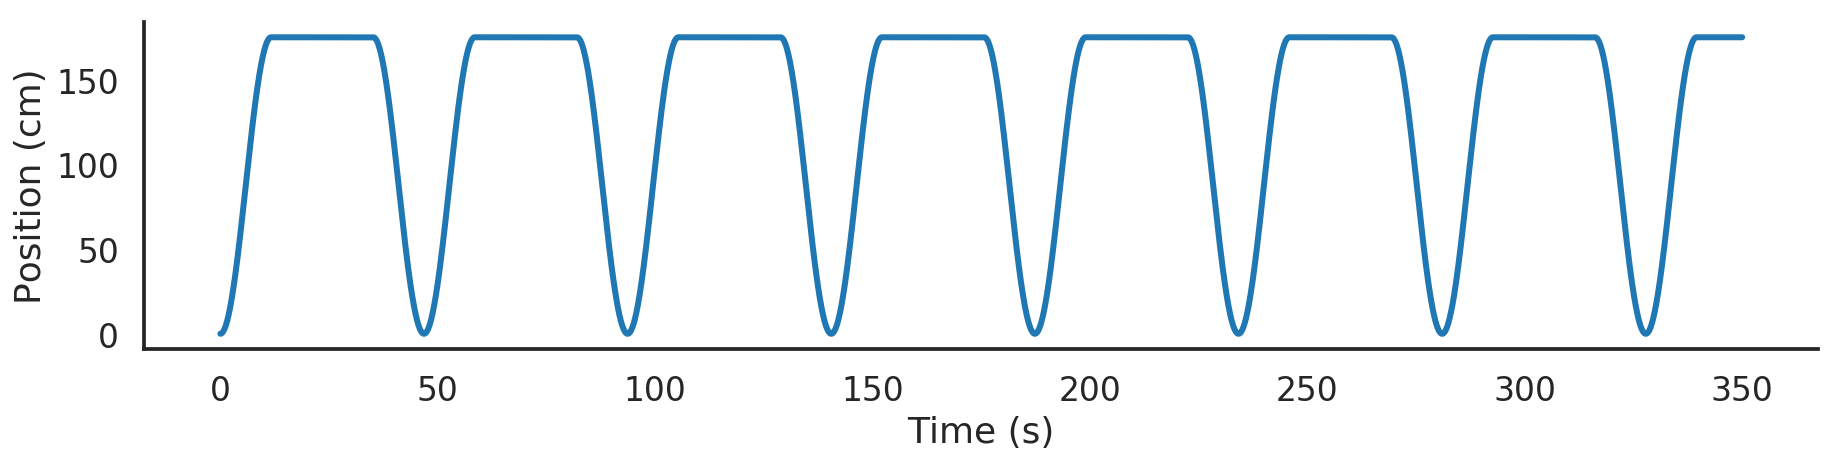

In [24]:
from replay_trajectory_classification.simulate import simulate_linear_distance_with_pauses

linear_distance2 = simulate_linear_distance_with_pauses(
    time, track_height, running_speed, pause=0.5, sampling_frequency=sampling_frequency)

plt.figure(figsize=(15, 3))
plt.plot(time, linear_distance2, linewidth=3)
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
sns.despine()

avg_speed = np.mean(np.abs(np.diff(linear_distance))) * sampling_frequency
avg_speed

(350000, 8)


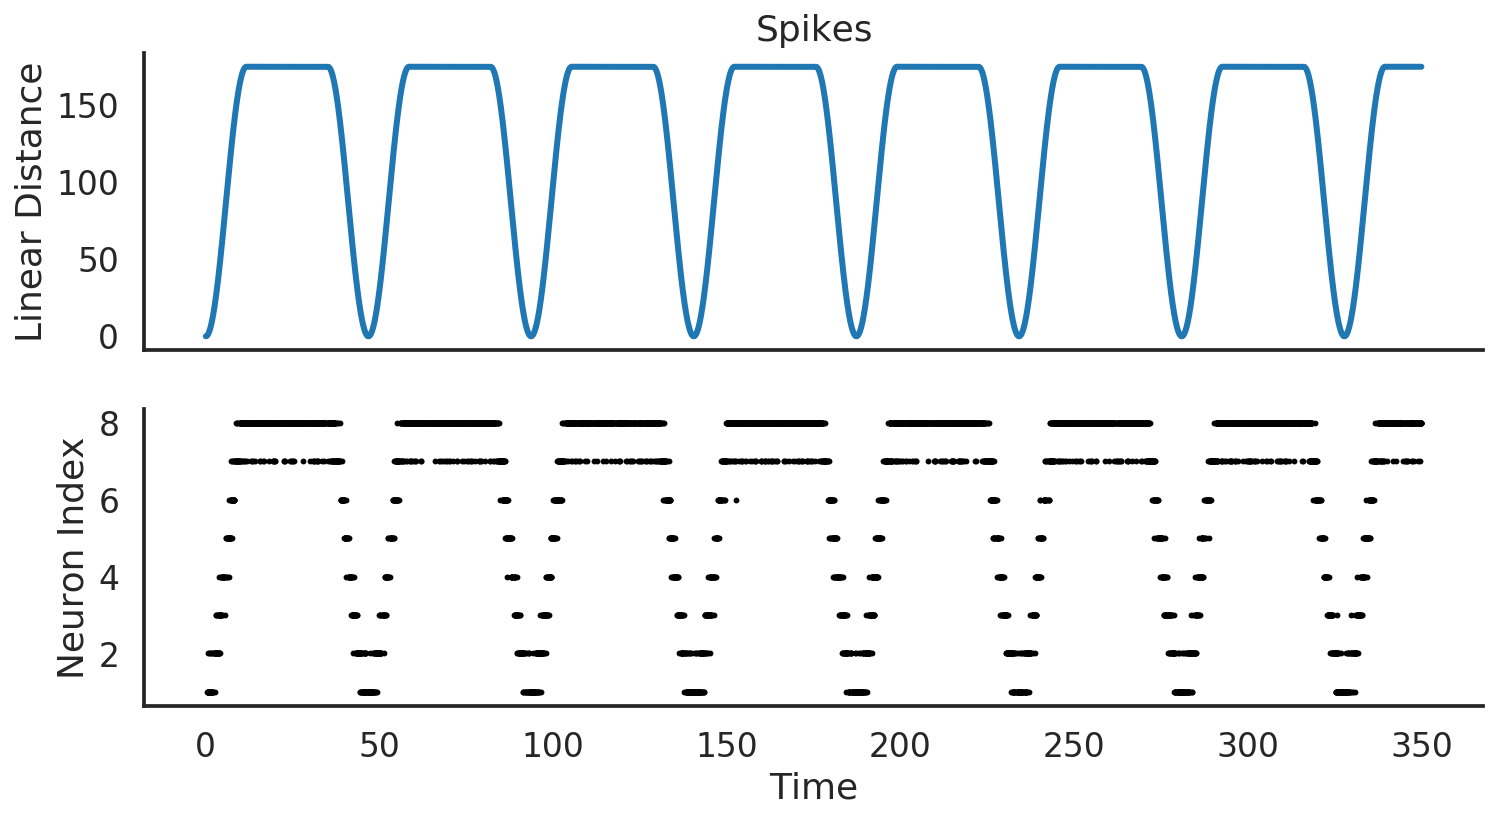

In [25]:
spikes2 = np.stack([simulate_neuron_with_place_field(
    place_field_mean, linear_distance2, max_rate=15, variance=144,
    sampling_frequency=sampling_frequency)
         for place_field_mean in place_field_means], axis=1)
print(spikes2.shape)

spike_ind, neuron_ind = np.nonzero(spikes2)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(time, linear_distance2, linewidth=3)
axes[0].set_ylabel('Linear Distance')
axes[0].set_title('Spikes')
axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_ylabel('Neuron Index')
axes[-1].set_xlabel('Time')
sns.despine()

In [26]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var2 = estimate_movement_var(linear_distance2, sampling_frequency)

continuous_transition_types = (
    [['random_walk', 'uniform', 'identity'],
     ['uniform', 'uniform', 'uniform'],
     ['random_walk', 'uniform', 'identity']])

classifier_no_speedup = SortedSpikesClassifier(movement_var=movement_var2,
                                    replay_speed=1,
                                    place_bin_size=np.sqrt(movement_var2),
                                    infer_track_interior=False,
                                    continuous_transition_types=continuous_transition_types,
                                    spike_model_penalty=0.5,
                                    discrete_transition_diag=(1 - 1E-4))
classifier_no_speedup.fit(linear_distance2, spikes2)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform', 'identity'], ['uniform', 'uniform', 'uniform'], ['random_walk', 'uniform', 'identity']],
            discrete_transition_diag=0.9999,
            discrete_transition_type='strong_diagonal',
            infer_track_interior=False,
            initial_conditions_type='uniform_on_track', knot_spacing=10,
            movement_var=0.13854334978850863,
            place_bin_size=0.3722141182014844, position_range=None,
            replay_speed=1, spike_model_penalty=0.5)

In [ ]:
results_no_speedup = classifier_no_speedup.predict(spikes2, time)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), constrained_layout=True, sharex=True)
axes[0].plot(time, linear_distance2, linewidth=3, color='black')
results_no_speedup.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1], linewidth=3)
results_no_speedup.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
sns.despine()

<xarray.DataArray 'acausal_posterior' (state: 3)>
array([0.999355, 0.164897, 0.992412])
Coordinates:
  * state    (state) <U26 'random_walk_minus_identity' ... 'identity'

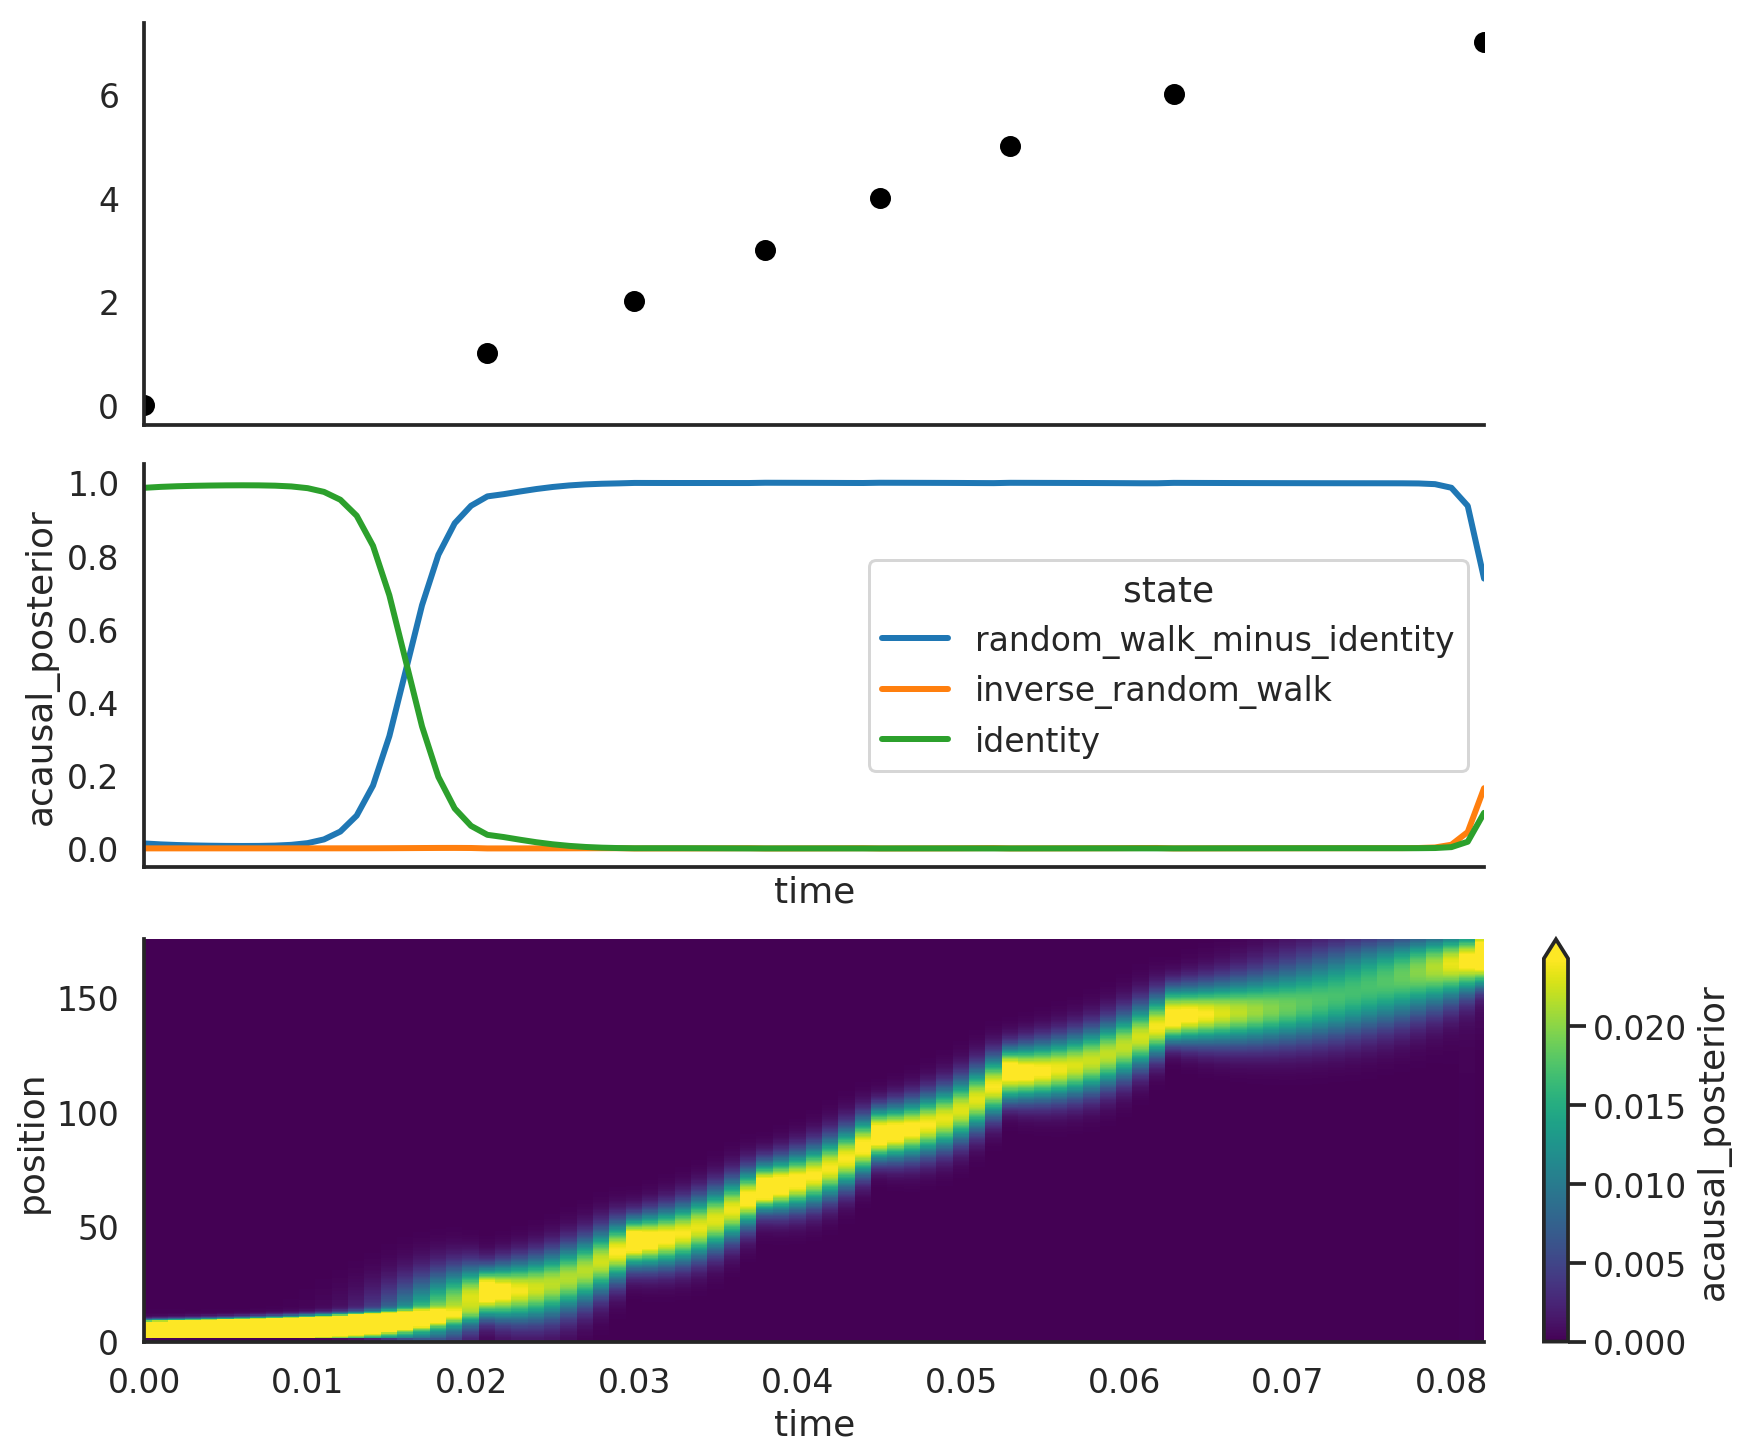

In [10]:
def get_replay_continuous(running_speed, sampling_frequency, track_height, replay_speedup=120, n_runs=0.5):
    replay_speed = running_speed * replay_speedup
    n_samples = int(n_runs * sampling_frequency * 2 * track_height / replay_speed)
    time = simulate_time(n_samples, sampling_frequency)
    linear_distance = simulate_linear_distance(time, track_height, replay_speed)
    
    return time, linear_distance

replay_time, replay_position = get_replay_continuous(
    running_speed, sampling_frequency, track_height, replay_speedup=140)

min_times_ind = np.argmin(np.abs(replay_position[:, np.newaxis] - place_field_means), axis=0)

n_neurons = spikes.shape[1]
test_spikes = np.zeros((replay_time.size, n_neurons))
test_spikes[(min_times_ind, np.arange(n_neurons),)] = 1.0

results = classifier.predict(test_spikes, replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
axes[0].scatter(replay_time[spike_time_ind],neuron_ind, color='black')
results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1], linewidth=3)
results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
plt.xlim((replay_time.min(), replay_time.max()))
sns.despine()
results.acausal_posterior.sum('position').max('time')

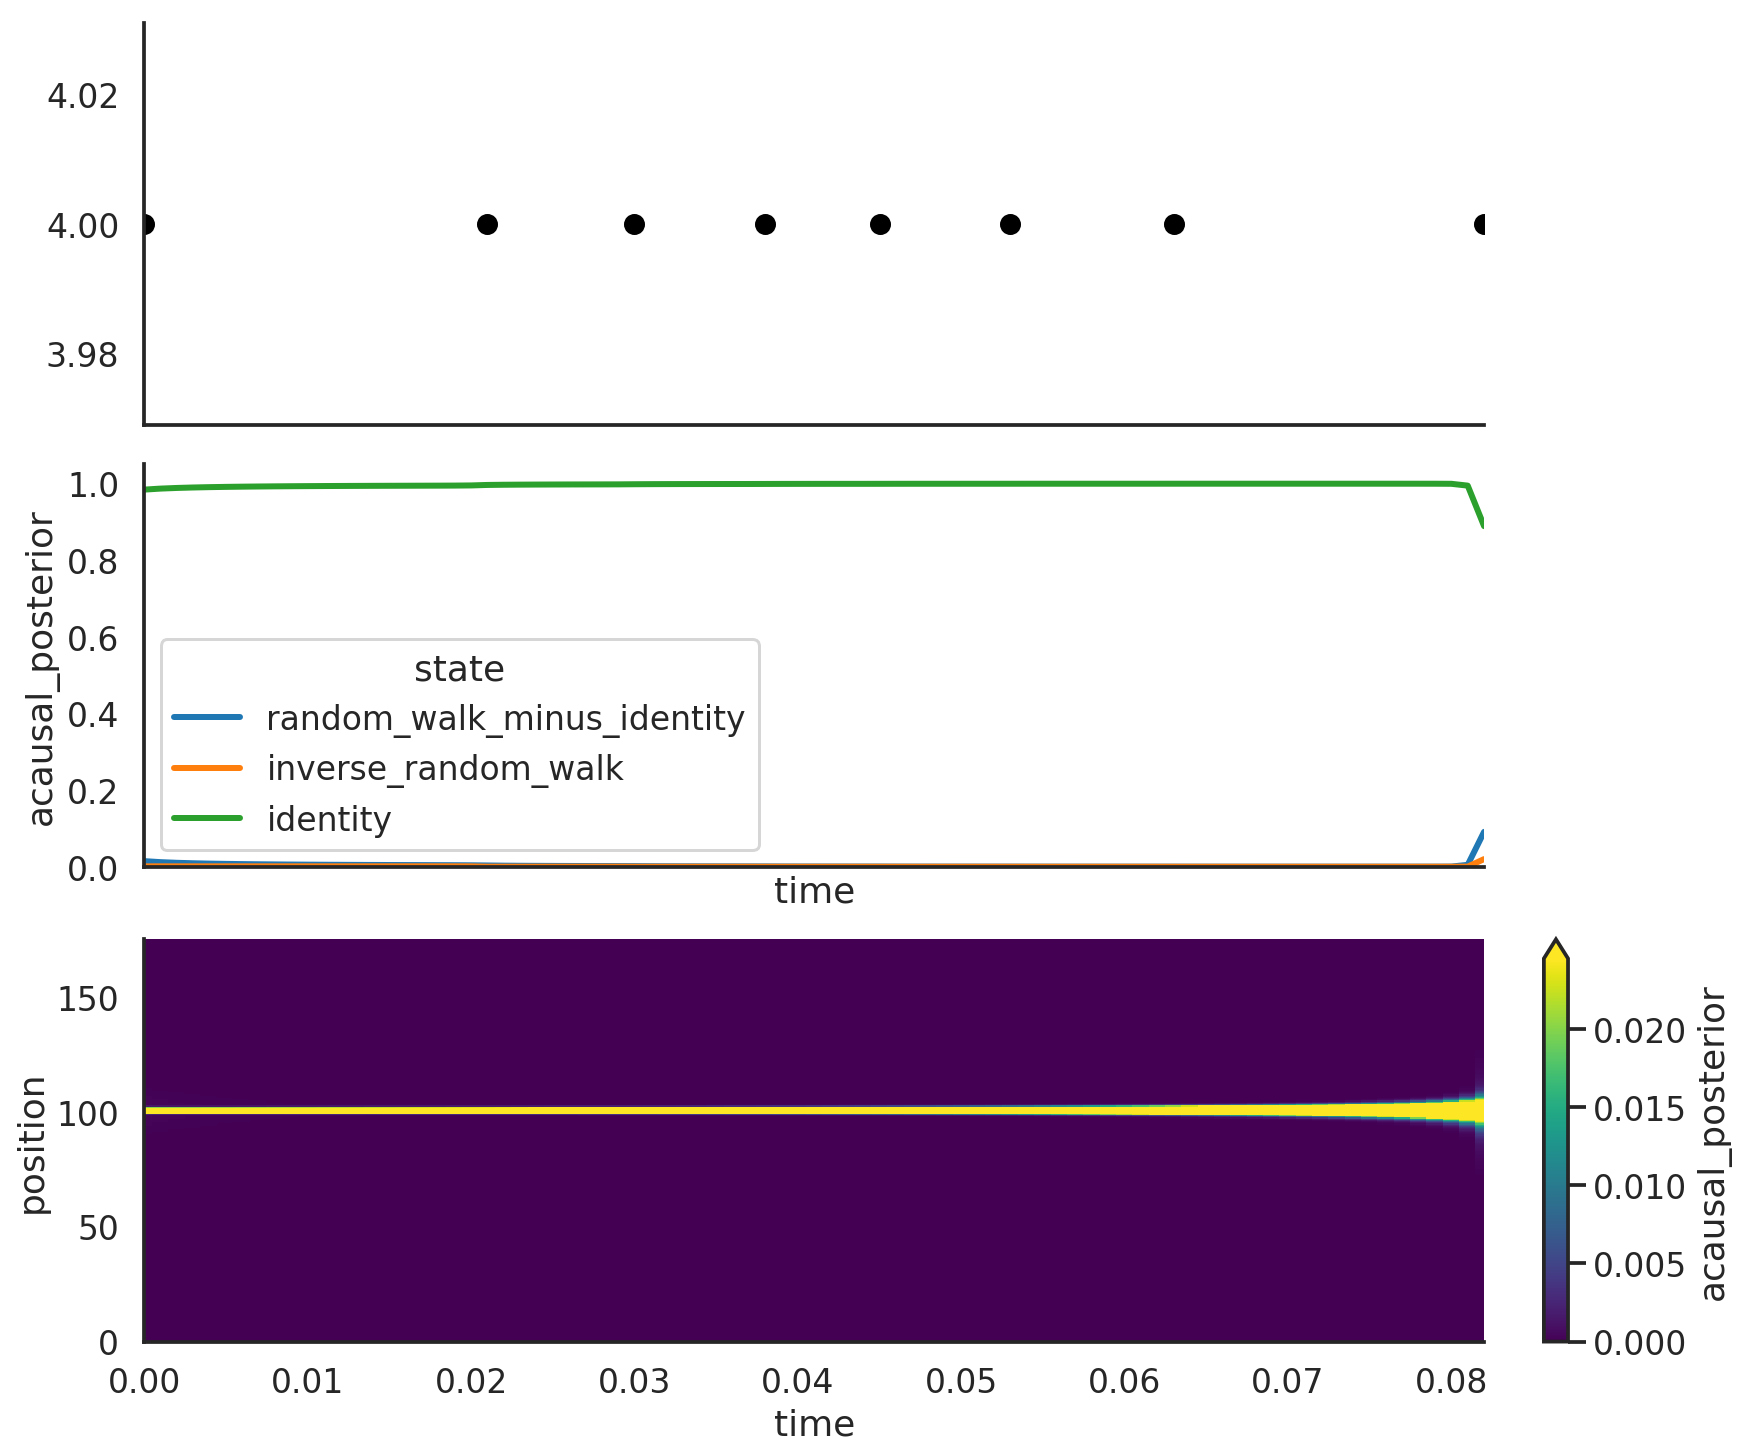

In [11]:
replay_time = np.arange(replay_position.shape[0]) / sampling_frequency
test_spikes = np.zeros((replay_time.size, n_neurons))
test_spikes[(min_times_ind, np.ones(n_neurons, dtype=np.int) * 4,)] = 1.0

results = classifier.predict(test_spikes, replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
axes[0].scatter(replay_time[spike_time_ind],neuron_ind, color='black')
results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1], linewidth=3)
axes[1].set_ylim((0, 1.05))
results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
plt.xlim((replay_time.min(), replay_time.max()))
sns.despine()

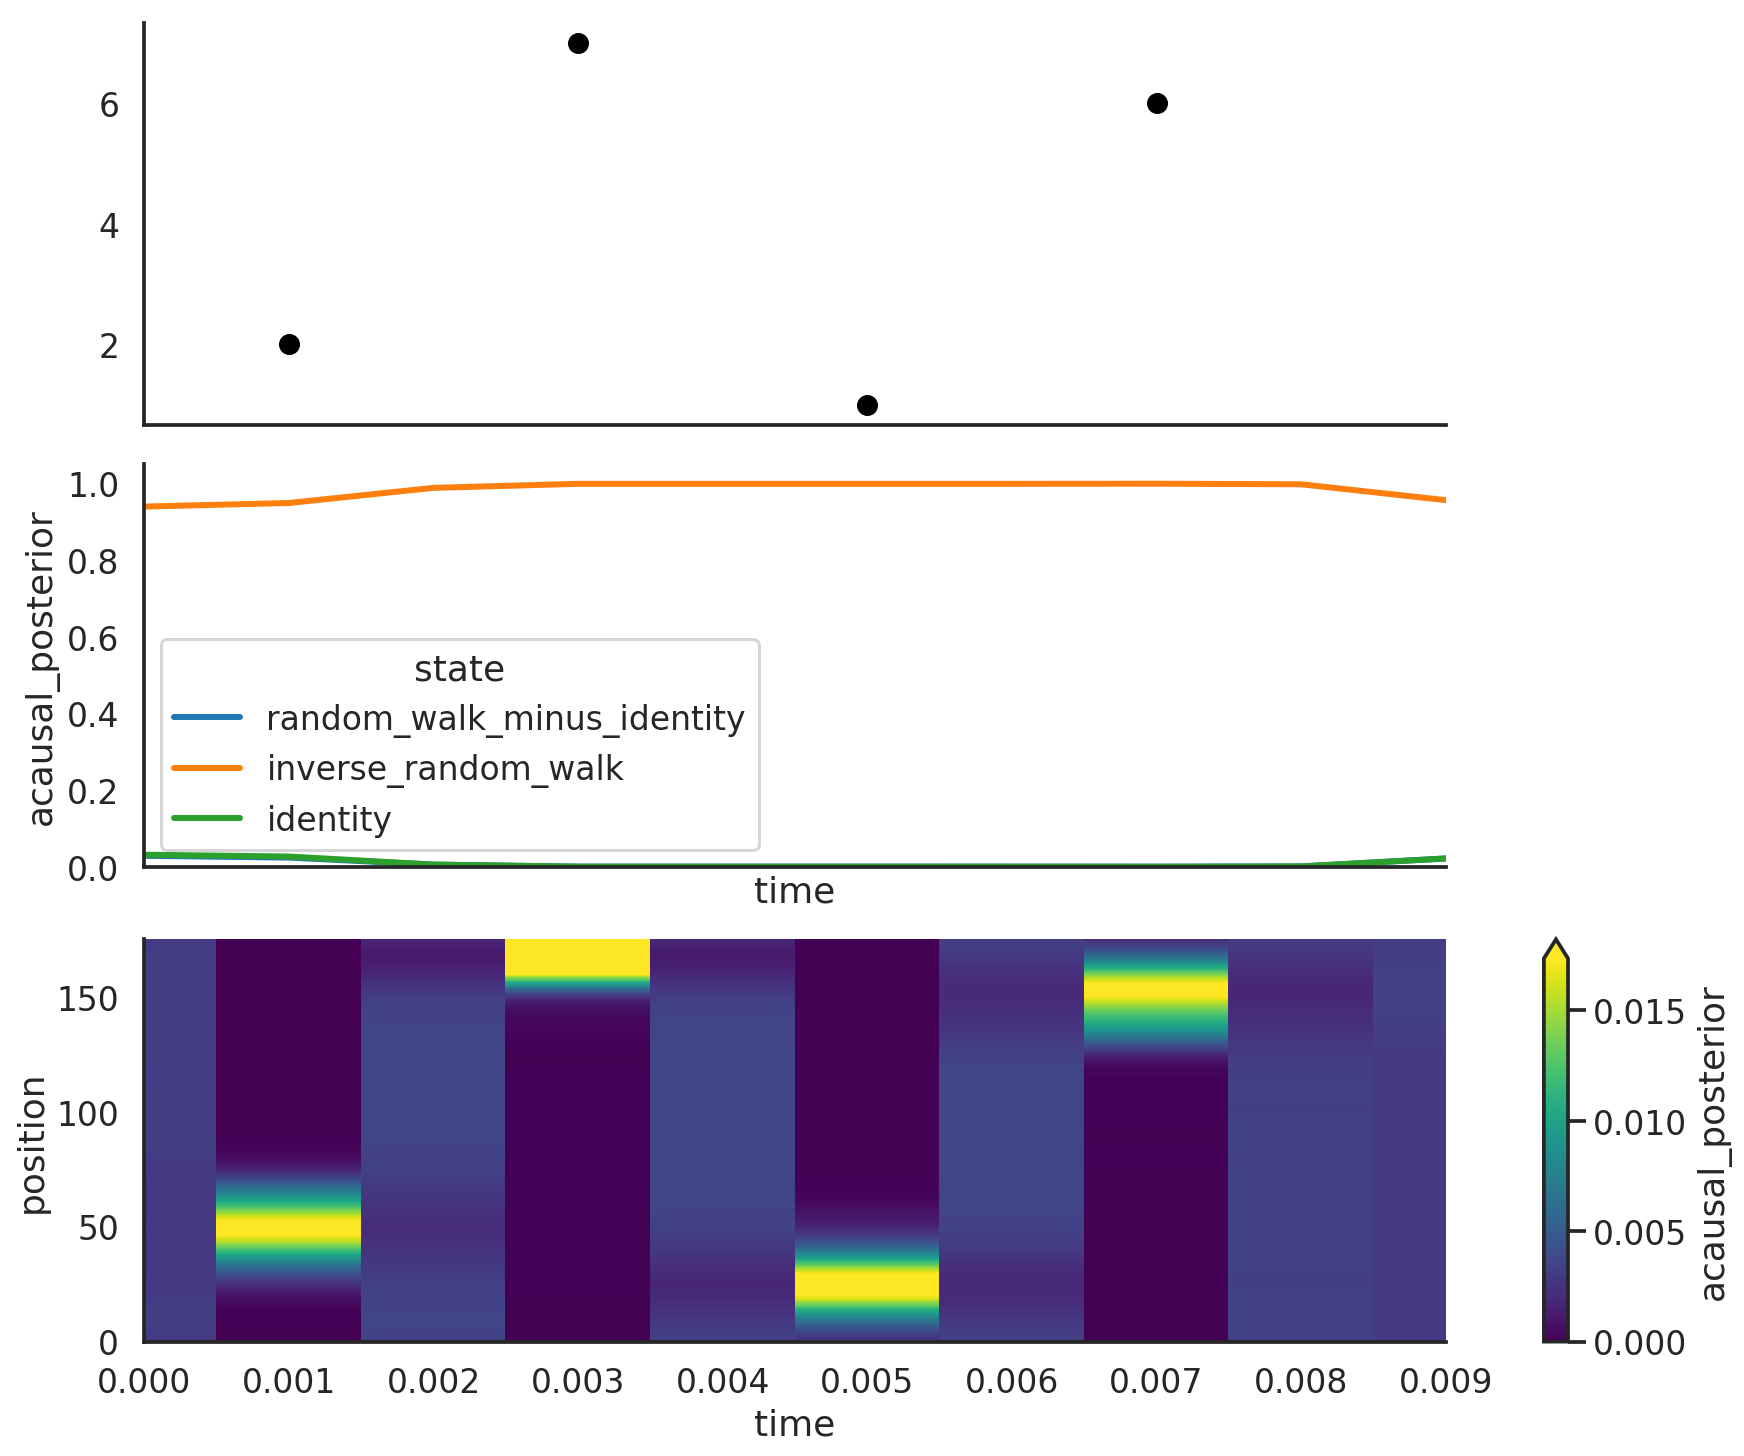

In [12]:
replay_time = np.arange(10) / sampling_frequency
ind = ([1, 3, 5, 7], [2, 7, 1, 6])
test_spikes = np.zeros((replay_time.shape[0], 8))
test_spikes[ind] = 1.0

results = classifier.predict(test_spikes, replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
axes[0].scatter(replay_time[spike_time_ind],neuron_ind, color='black')
results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1], linewidth=3)
axes[1].set_ylim((0, 1.05))
results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
plt.xlim((replay_time.min(), replay_time.max()))
sns.despine()

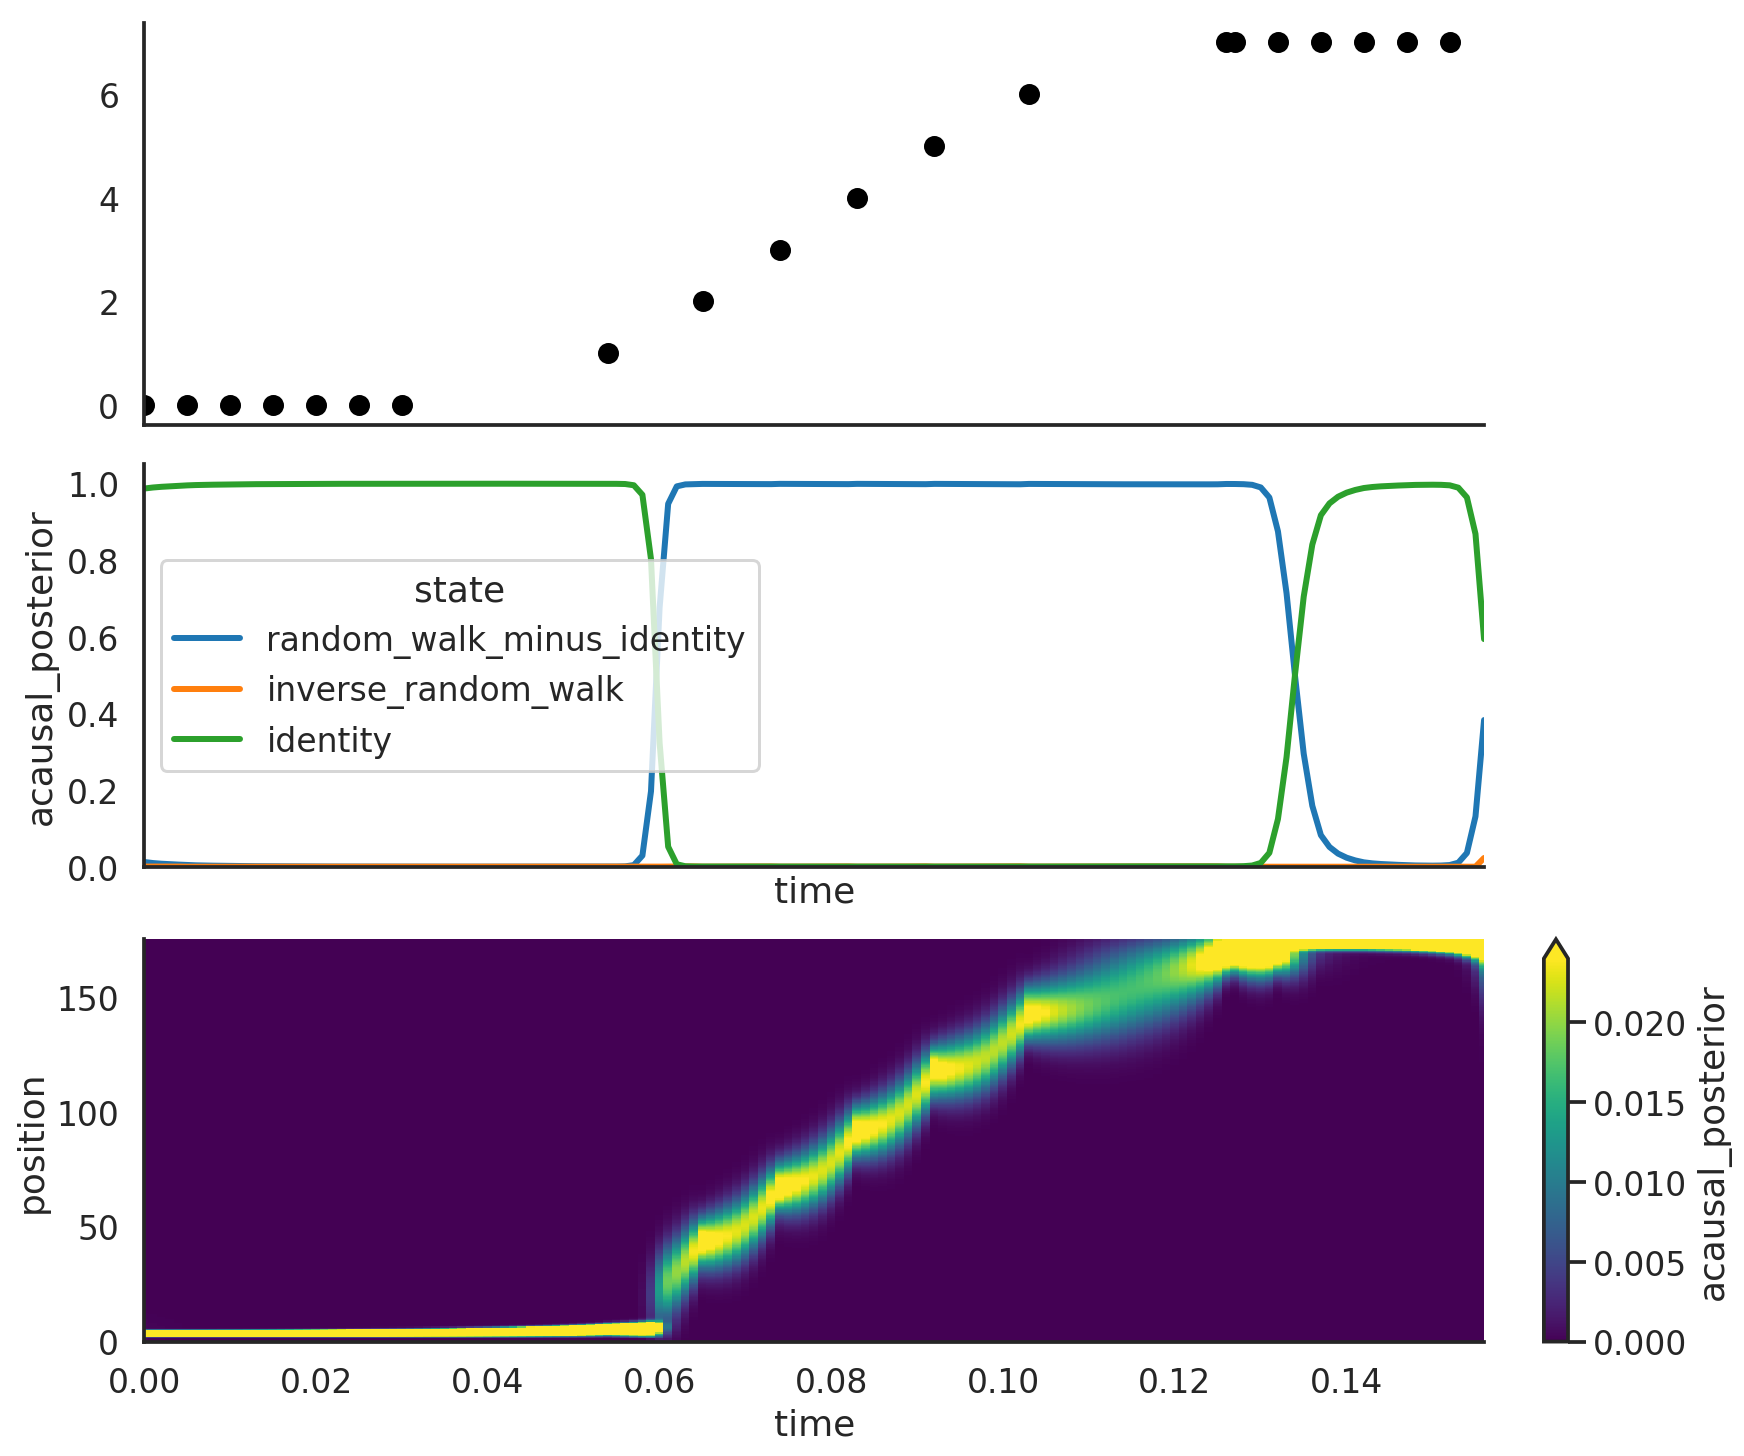

In [13]:
replay_time, replay_position = get_replay_continuous(
    running_speed, sampling_frequency, track_height, replay_speedup=120)

min_times_ind = np.argmin(np.abs(replay_position[:, np.newaxis] - place_field_means), axis=0)

test_spikes1 = np.zeros((30, n_neurons))
test_spikes1[(np.arange(0, 30, 5), np.ones(6, dtype=np.int) * 0)] = 1.0

test_spikes2 = np.zeros((replay_time.size, n_neurons))
test_spikes2[(min_times_ind, np.arange(n_neurons),)] = 1.0

test_spikes3 = np.zeros((30, n_neurons))
test_spikes3[(np.arange(0, 30, 5), np.ones(6, dtype=np.int) * (n_neurons - 1),)] = 1.0

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes3))

replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

results = classifier.predict(test_spikes, replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
axes[0].scatter(replay_time[spike_time_ind],neuron_ind, color='black')
results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1], linewidth=3)
axes[1].set_ylim((0, 1.05))
results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
plt.xlim((replay_time.min(), replay_time.max()))
sns.despine()

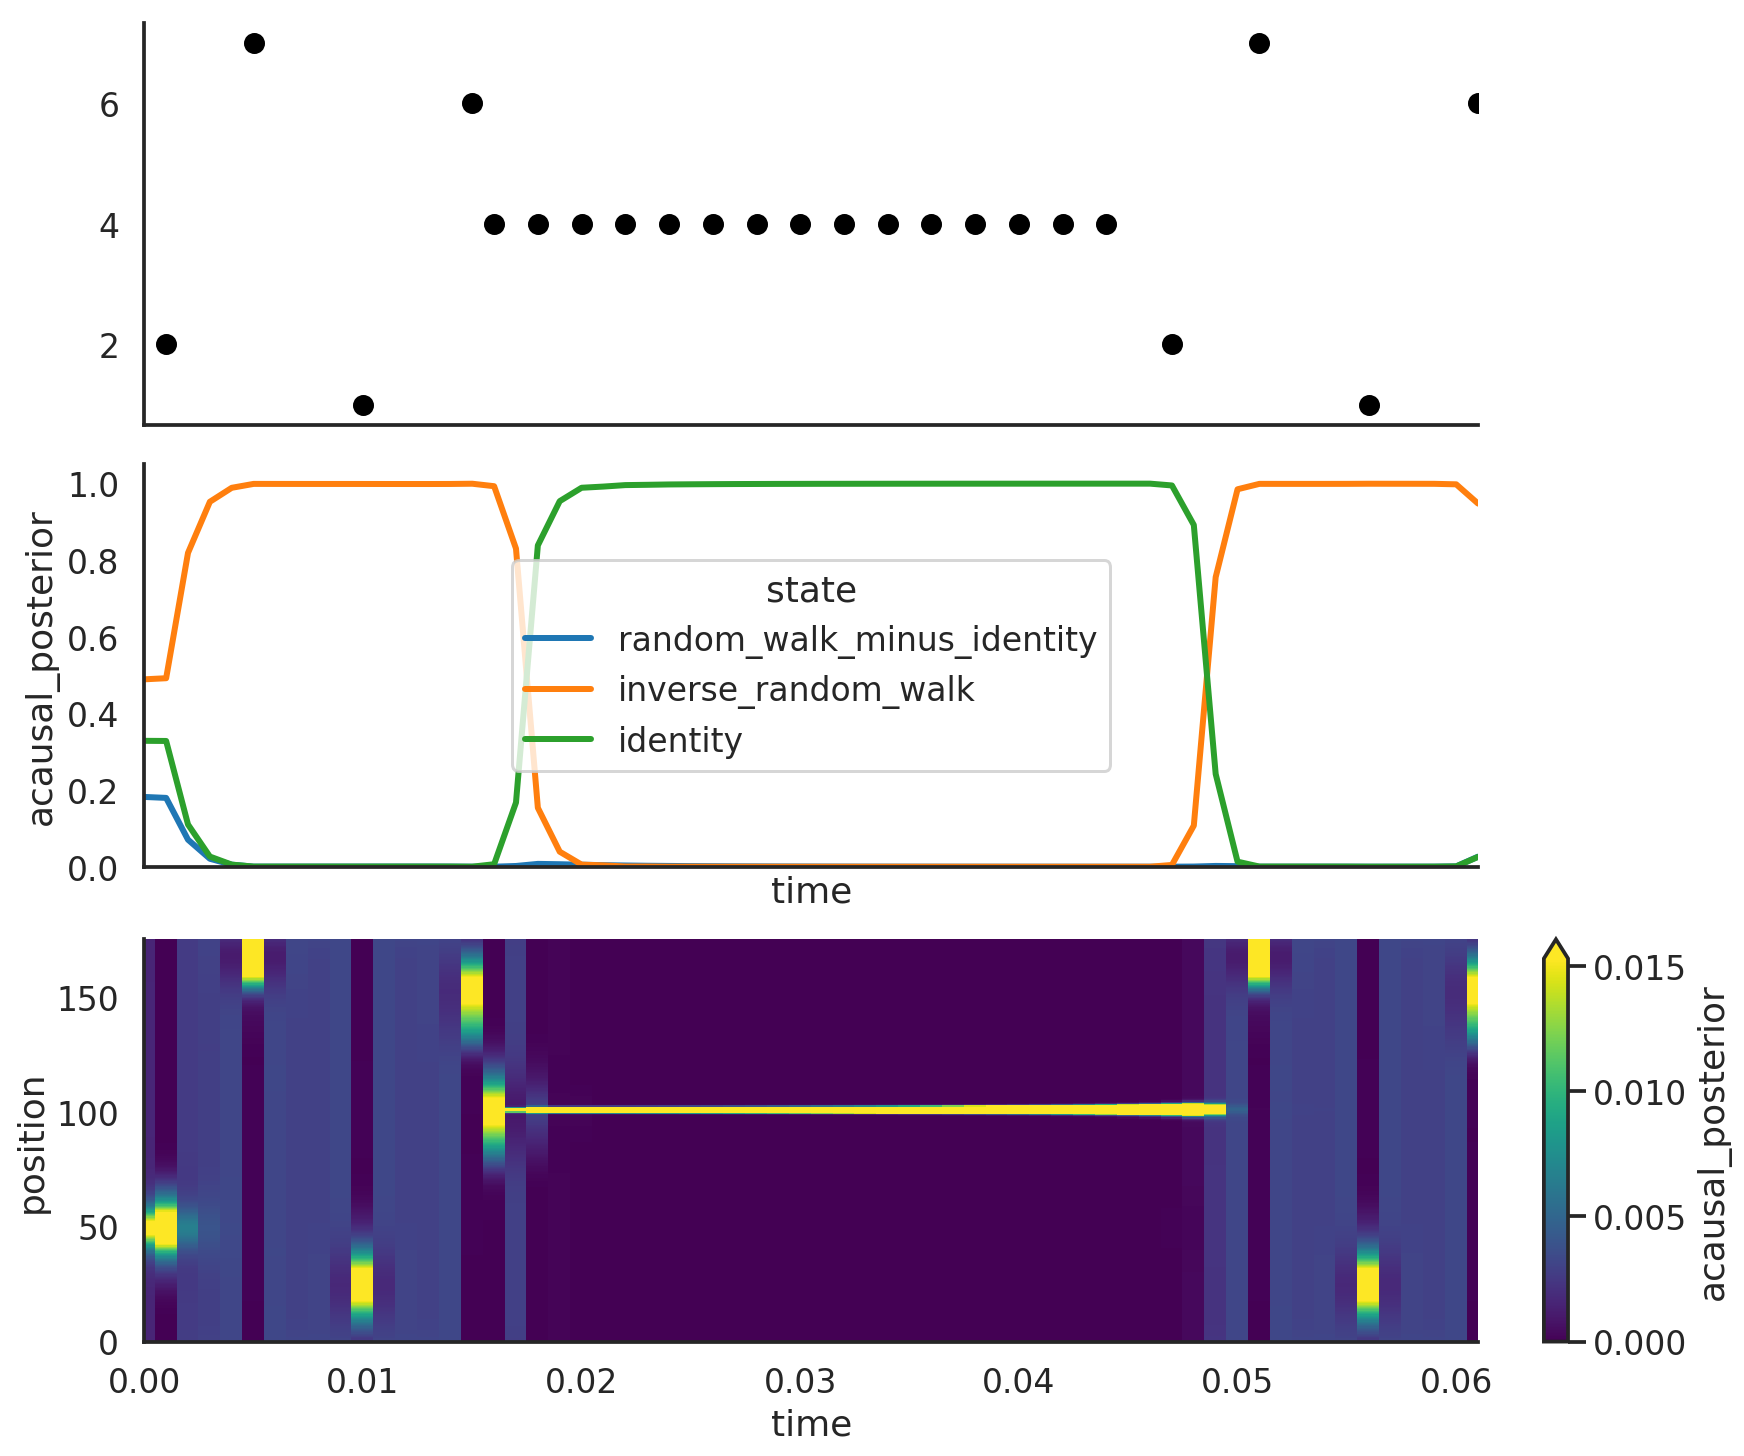

In [14]:
ind = ([1, 5, 10, 15], [2, n_neurons - 1, 1, n_neurons-2])
test_spikes1 = np.zeros((16, n_neurons))
test_spikes1[ind] = 1.0

test_spikes2 = np.zeros((30, n_neurons))
test_spikes2[::2, 4] = 1

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes1))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

results = classifier.predict(test_spikes, replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
axes[0].scatter(replay_time[spike_time_ind],neuron_ind, color='black')
results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1], linewidth=3)
axes[1].set_ylim((0, 1.05))
results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
plt.xlim((replay_time.min(), replay_time.max()))
sns.despine()

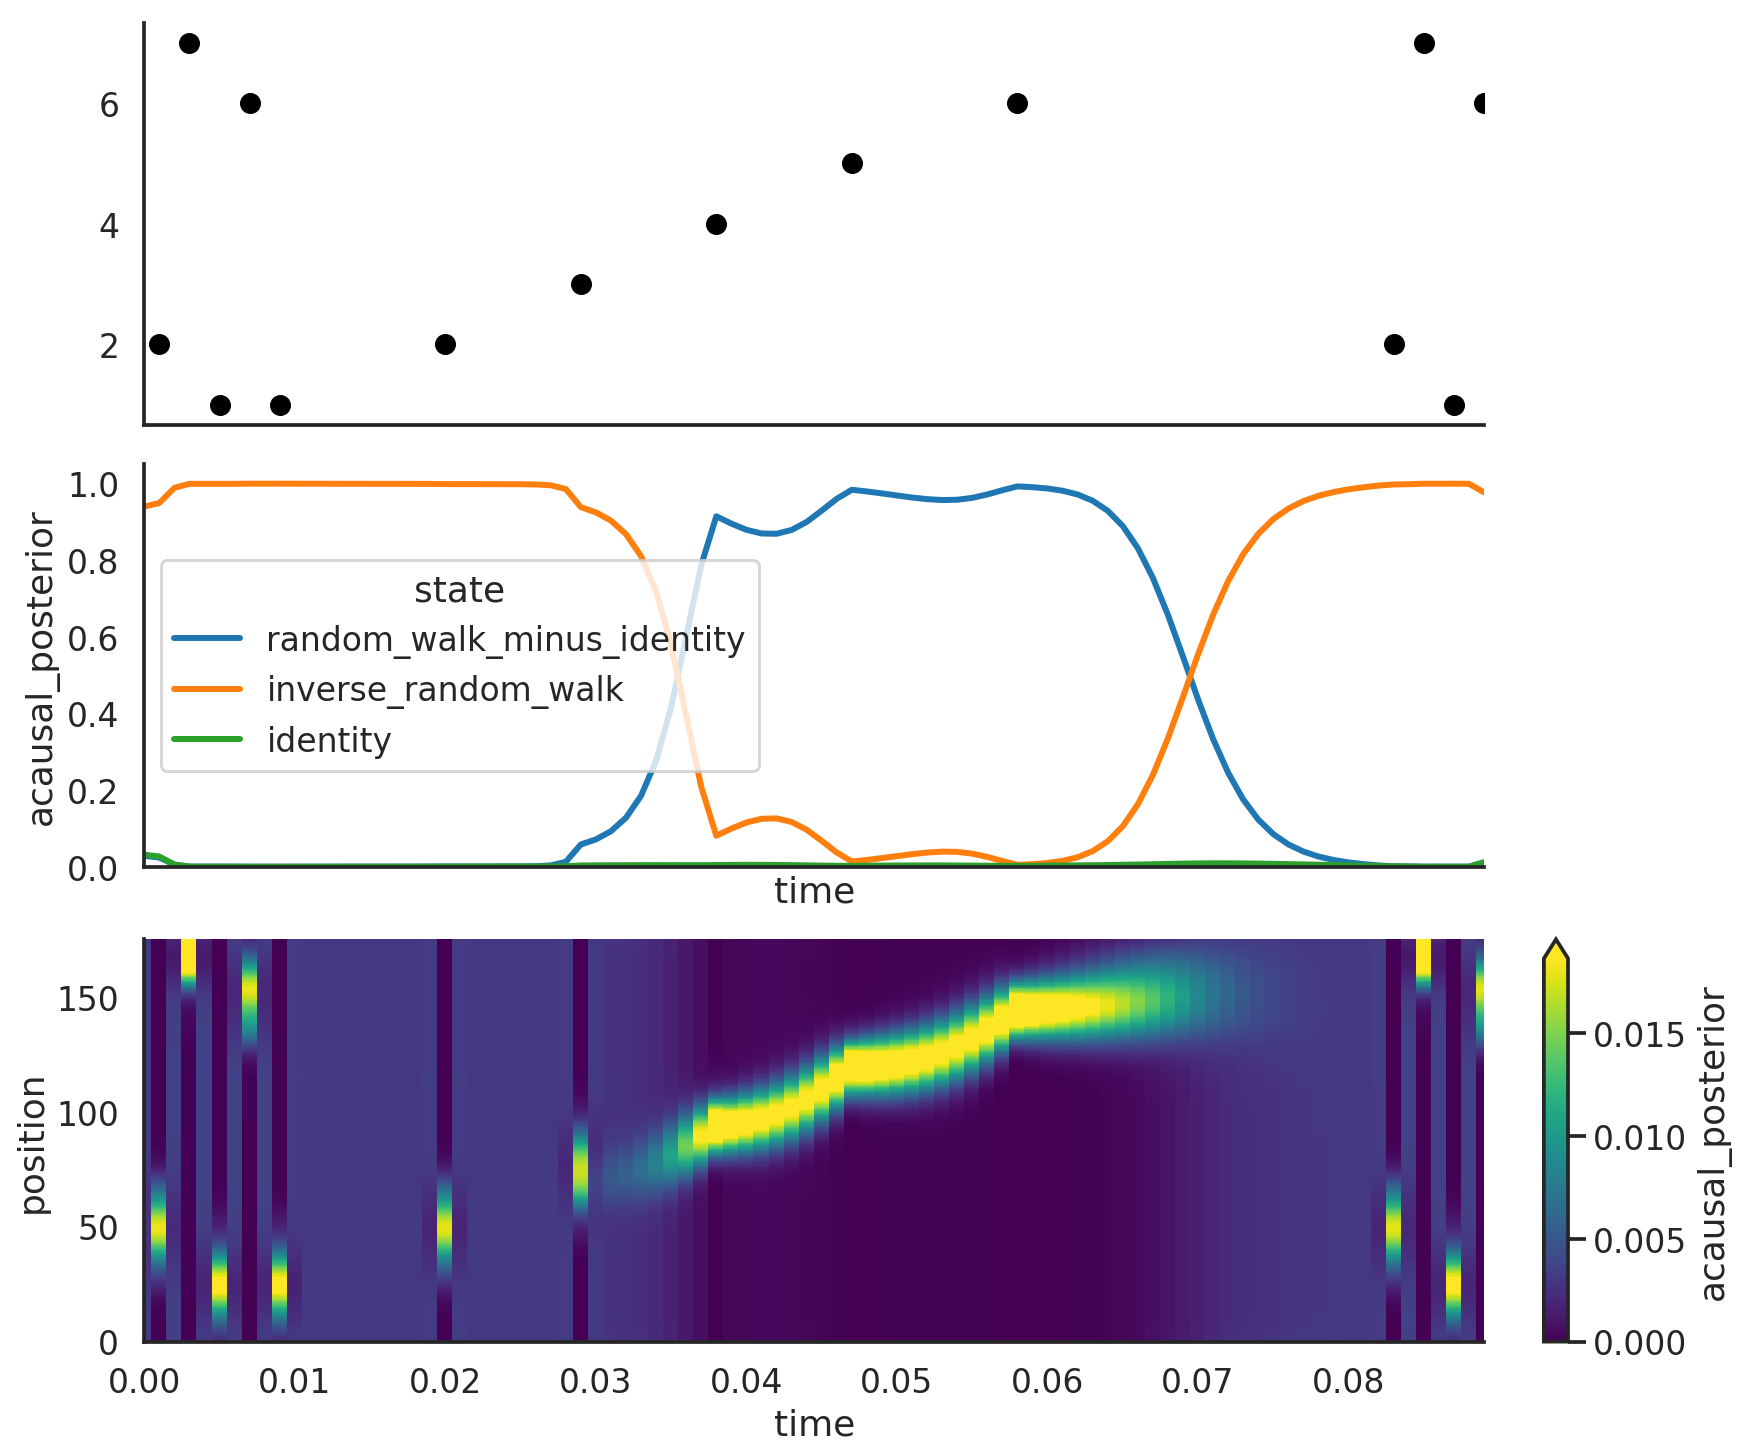

In [15]:
replay_time, replay_position = get_replay_continuous(
    running_speed, sampling_frequency, track_height, replay_speedup=120)

min_times_ind = np.argmin(np.abs(replay_position[:, np.newaxis] - place_field_means), axis=0)

test_spikes2 = np.zeros((min_times_ind[1:-1].max() + 1, n_neurons))
test_spikes2[(min_times_ind[1:-1] - min_times_ind[1] + 1, np.arange(1, n_neurons -1),)] = 1.0

ind = ([1, 3, 5, 7], [2, 7, 1, 6])
test_spikes1 = np.zeros((8, n_neurons))
test_spikes1[ind] = 1.0

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes1))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

results = classifier.predict(test_spikes, replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
axes[0].scatter(replay_time[spike_time_ind],neuron_ind, color='black')
results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1], linewidth=3)
axes[1].set_ylim((0, 1.05))
results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
plt.xlim((replay_time.min(), replay_time.max()))
sns.despine()

In [463]:
import os
from tqdm.autonotebook import tqdm

folder = 'fragmented_continuous'
os.makedirs(folder, exist_ok=True)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)

for t_ind, t in enumerate(tqdm(results.time)):
# t_ind, t = 0, results.time[0]
    fig, axes = plt.subplots(4, 1, figsize=(7, 10), constrained_layout=True)
    for s_ind, state in enumerate(results.state):
        results.causal_posterior.sel(time=t, state=state).plot(x='position', linewidth=5, ax=axes[s_ind])
        axes[s_ind].set_xlim((0, results.position.max()))
        axes[s_ind].set_ylim((0, results.causal_posterior.sel(time=t, state=state).max()))
        axes[s_ind].set_ylabel('Posterior')

    axes[3].scatter(results.time[spike_time_ind], neuron_ind)
    axes[3].axvline(np.asarray(t))
    axes[3].set_xlabel('Time')
    axes[3].set_ylabel('Neuron Index')
    axes[3].set_yticks([])
    sns.despine()
    figure_name = (f'temp_{t_ind:04d}.png')
    figure_path = os.path.join(folder, figure_name)
    plt.savefig(figure_path, bbox_inches='tight')
    plt.close(plt.gcf())

In [16]:
from numba import njit

def logsumexp_numpy(a):
    a_max = np.max(a)
    out = np.log(np.sum(np.exp(a - a_max)))
    out += a_max
    return out


@njit(nogil=True, fastmath=True)
def logsumexp_njit(a):
    a_max = np.max(a)
    out = np.log(np.sum(np.exp(a - a_max)))
    out += a_max
    return out

In [21]:
%%timeit

a = np.arange(10)
logsumexp_numpy(a)

13.7 µs ± 400 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
%%timeit

a = np.arange(10)
logsumexp_njit(a)

1.21 µs ± 31.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [23]:
a = np.arange(10)
np.allclose(logsumexp_numpy(a), logsumexp_njit(a))

True

In [24]:
from scipy.special import logsumexp
a = np.arange(10)
np.allclose(logsumexp(a), logsumexp_njit(a))

True

In [25]:
%%timeit

a = np.arange(10)
logsumexp(a)

35 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
